# Load

In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import sqlite3
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import itertools
import scipy

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.2.


Data

In [2]:
all_surveys = pd.read_excel("C:/Users/Durugshan/Google Drive/Education/University - MMA/Courses/MMA 869 - Machine Learning & AI/Team Project/Source Files/All Surveys 2018 and 2019 Jan-June Extract_FixedDates.xlsx")
service_1= pd.read_excel("C:/Users/Durugshan/Google Drive/Education/University - MMA/Courses/MMA 869 - Machine Learning & AI/Team Project/Source Files/Service_TBS.xlsx")
service_2 = pd.read_csv("C:/Users/Durugshan/Google Drive/Education/University - MMA/Courses/MMA 869 - Machine Learning & AI/Team Project/Source Files/newservicedata_TBS.csv")
vehicle_purchase = pd.read_excel("C:/Users/Durugshan/Google Drive/Education/University - MMA/Courses/MMA 869 - Machine Learning & AI/Team Project/Source Files/Vehicle Purchase_TBS.xlsx")
retailer_lookup = pd.read_excel("C:/Users/Durugshan/Google Drive/Education/University - MMA/Courses/MMA 869 - Machine Learning & AI/Team Project/Source Files/retailerlookuplist.xlsx")

In [3]:
#all_surveys = pd.read_excel("C:/Users/s5662866/Downloads/BMW/BMW All Surveys 2018 and 2019 Jan-June Extract/BMW All Surveys 2018 and 2019 Jan-June Extract/All Surveys 2018 and 2019 Jan-June Extract_FixedDates.xlsx")
##service_1 = pd.read_excel("C:/Users/s5662866/Downloads/BMW/BMW All Surveys 2018 and 2019 Jan-June Extract/BMW All Surveys 2018 and 2019 Jan-June Extract/Service_TBS.xlsx")
#service_2 = pd.read_csv("C:/Users/s5662866/Downloads/BMW/BMW All Surveys 2018 and 2019 Jan-June Extract/BMW All Surveys 2018 and 2019 Jan-June Extract/newservicedata_TBS.csv")
#vehicle_purchase = pd.read_excel("C:/Users/s5662866/Downloads/BMW/BMW All Surveys 2018 and 2019 Jan-June Extract/BMW All Surveys 2018 and 2019 Jan-June Extract/Vehicle Purchase_TBS.xlsx")
#retailer_lookup = pd.read_excel("C:/Users/s5662866/Downloads/BMW/BMW All Surveys 2018 and 2019 Jan-June Extract/BMW All Surveys 2018 and 2019 Jan-June Extract/retailerlookuplist.xlsx")

# Data Processing

### Survey data

In [4]:
#view columns in survey
for col in all_surveys.columns: 
    print(col) 

RespondentId
SampleReceivedDate
dealer_nme
dealer_no
InvitationStatus
DispositionDetail
ResponseStatus
Associatenumber
vin
UniqueID
Brand
Channel
SurveyType
Metro
EventDate
RO_NUM
InvitationDate
OptOutStatus
RegionID
CompletedDate


In [5]:
all_surveys['Brand'].unique()

array(['BMW', 'MINI', 'BMW i', 'Motorrad', nan], dtype=object)

In [6]:
#delete rows for MINI, Motorrad, nan
print(len(all_surveys))
print(len(all_surveys[(all_surveys['Brand'] == 'Motorrad') | (all_surveys['Brand'] == 'MINI')]))

all_surveys = all_surveys[(all_surveys['Brand'] == 'BMW') | (all_surveys['Brand'] == 'BMW i')]
print(len(all_surveys))

690422
100444
589962


In [7]:
#view columns in service_1 and service_2
for col in service_1.columns: 
    print(col)
for col in service_2.columns: 
    print(col)

vin
id
RO_NUM
dealer_nme: 
dealer_no
city
ODOMTR_RDNG
service_adv_no
ServiceInD
ServiceOut
PaymentType
CustomerpaidAmt_New
WarrantyAmt_New
vin
id
RO_NUM
dealer_name
ODOMTR_RDNG
ServiceInD
ServiceOut
PaymentType
CustomerpaidAmt_New
WarrantyAmt_New
data


### Service data

In [8]:
#clean column names and drop data column
service_1.columns = ['vin','id','RO_NUM','dealer_name','dealer_no','city','ODOMTR_RDNG','service_adv_no','ServiceInD','ServiceOut','PaymentType','CustomerpaidAmt_New', 'WarrantyAmt_New']
service_1 = service_1.drop(['dealer_no', 'city', 'service_adv_no'], axis=1)

In [9]:
#clean column names and drop data column
service_2.columns = ['vin','id','RO_NUM','dealer_name','ODOMTR_RDNG','ServiceInD','ServiceOut','PaymentType','CustomerpaidAmt_New', 'WarrantyAmt_New', 'data']
service_2 = service_2.drop(['data'], axis=1)

In [10]:
#view columns in service_1 and service_2
for col in service_1.columns: 
    print(col)
for col in service_2.columns: 
    print(col)

vin
id
RO_NUM
dealer_name
ODOMTR_RDNG
ServiceInD
ServiceOut
PaymentType
CustomerpaidAmt_New
WarrantyAmt_New
vin
id
RO_NUM
dealer_name
ODOMTR_RDNG
ServiceInD
ServiceOut
PaymentType
CustomerpaidAmt_New
WarrantyAmt_New


In [11]:
#bind the rows
service_3 = service_1.append(pd.DataFrame(data = service_2), ignore_index=True)

In [12]:
service_3.head(10)

,vin,id,RO_NUM,dealer_name,ODOMTR_RDNG,ServiceInD,ServiceOut,PaymentType,CustomerpaidAmt_New,WarrantyAmt_New
0,494DP70460,1410383.0,289999.0,BMW Richmond Hill Service,269500.0,2018-06-21 00:00:00,2018-06-25 00:00:00,Customer Pay Only,118.00,0.0
1,547KX54149,1410400.0,94535.0,Budds' BMW Hamilton,292969.0,2019-02-09 00:00:00,2019-02-09 00:00:00,Customer Pay Only,0.00,0.0
2,547KX54149,1410400.0,94535.0,Budds' BMW Hamilton,292969.0,2019-02-09 00:00:00,2019-02-09 00:00:00,Customer Pay Only,90.43,0.0
3,5X8K043959,1410405.0,328614.0,Pfaff BMW,148243.0,2018-01-02 00:00:00,2018-01-04 00:00:00,Customer Pay Only,0.00,0.0
4,5X8K043959,1410405.0,328614.0,Pfaff BMW,148243.0,2018-01-02 00:00:00,2018-01-04 00:00:00,Customer Pay Only,135.00,0.0
5,53ALT84645,1410414.0,362885.0,The BMW Store,118090.0,2018-01-10 00:00:00,2018-01-24 00:00:00,Customer Pay Only,0.00,0.0
6,53ALT84645,1410414.0,362885.0,The BMW Store,118090.0,2018-01-10 00:00:00,2018-01-24 00:00:00,Customer Pay Only,77.37,0.0
7,53ALT84645,1410414.0,362885.0,The BMW Store,118090.0,2018-01-10 00:00:00,2018-01-24 00:00:00,Customer Pay Only,149.75,0.0
8,53ALT84645,1410414.0,362885.0,The BMW Store,118090.0,2018-01-10 00:00:00,2018-01-24 00:00:00,Customer Pay Only,2674.62,0.0
9,53ALT84645,1410414.0,363956.0,The BMW Store,118428.0,2018-01-31 00:00:00,2018-02-10 00:00:00,Customer Pay Only,0.00,0.0


In [13]:
service_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896006 entries, 0 to 2896005
Data columns (total 10 columns):
vin                    object
id                     float64
RO_NUM                 float64
dealer_name            object
ODOMTR_RDNG            float64
ServiceInD             object
ServiceOut             object
PaymentType            object
CustomerpaidAmt_New    float64
WarrantyAmt_New        float64
dtypes: float64(5), object(5)
memory usage: 220.9+ MB


In [14]:
#view columns in service
service = service_3
cols = ['vin','id','RO_NUM','dealer_name','ODOMTR_RDNG','ServiceInD','ServiceOut','PaymentType','CustomerpaidAmt_New', 'WarrantyAmt_New']
service = service[cols]
for col in service.columns: 
    print(col) 

vin
id
RO_NUM
dealer_name
ODOMTR_RDNG
ServiceInD
ServiceOut
PaymentType
CustomerpaidAmt_New
WarrantyAmt_New


In [15]:
service.head(20)

,vin,id,RO_NUM,dealer_name,ODOMTR_RDNG,ServiceInD,ServiceOut,PaymentType,CustomerpaidAmt_New,WarrantyAmt_New
0,494DP70460,1410383.0,289999.0,BMW Richmond Hill Service,269500.0,2018-06-21 00:00:00,2018-06-25 00:00:00,Customer Pay Only,118.00,0.00
1,547KX54149,1410400.0,94535.0,Budds' BMW Hamilton,292969.0,2019-02-09 00:00:00,2019-02-09 00:00:00,Customer Pay Only,0.00,0.00
2,547KX54149,1410400.0,94535.0,Budds' BMW Hamilton,292969.0,2019-02-09 00:00:00,2019-02-09 00:00:00,Customer Pay Only,90.43,0.00
3,5X8K043959,1410405.0,328614.0,Pfaff BMW,148243.0,2018-01-02 00:00:00,2018-01-04 00:00:00,Customer Pay Only,0.00,0.00
4,5X8K043959,1410405.0,328614.0,Pfaff BMW,148243.0,2018-01-02 00:00:00,2018-01-04 00:00:00,Customer Pay Only,135.00,0.00
5,53ALT84645,1410414.0,362885.0,The BMW Store,118090.0,2018-01-10 00:00:00,2018-01-24 00:00:00,Customer Pay Only,0.00,0.00
6,53ALT84645,1410414.0,362885.0,The BMW Store,118090.0,2018-01-10 00:00:00,2018-01-24 00:00:00,Customer Pay Only,77.37,0.00
7,53ALT84645,1410414.0,362885.0,The BMW Store,118090.0,2018-01-10 00:00:00,2018-01-24 00:00:00,Customer Pay Only,149.75,0.00
8,53ALT84645,1410414.0,362885.0,The BMW Store,118090.0,2018-01-10 00:00:00,2018-01-24 00:00:00,Customer Pay Only,2674.62,0.00
9,53ALT84645,1410414.0,363956.0,The BMW Store,118428.0,2018-01-31 00:00:00,2018-02-10 00:00:00,Customer Pay Only,0.00,0.00


In [16]:
#drop duplicates
service = service.drop_duplicates()

In [17]:
service.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2617055 entries, 0 to 2895983
Data columns (total 10 columns):
vin                    object
id                     float64
RO_NUM                 float64
dealer_name            object
ODOMTR_RDNG            float64
ServiceInD             object
ServiceOut             object
PaymentType            object
CustomerpaidAmt_New    float64
WarrantyAmt_New        float64
dtypes: float64(5), object(5)
memory usage: 219.6+ MB


In [18]:
#since there are repeats for payments under every field until payment type, group by those fields
service_grouped = service.groupby(['vin','id','RO_NUM','dealer_name','ODOMTR_RDNG','ServiceInD','ServiceOut','PaymentType'], as_index = False).agg(np.sum)

In [19]:
#check if those with customer paid and warranty paid are both above 0
service_grouped['IsCustAndWarr'] = (service_grouped['CustomerpaidAmt_New'] > 0) & (service_grouped['WarrantyAmt_New'] > 0)
service_grouped['IsCustAndWarr'].nunique() #only see False so each observation only has one type of payment

1

In [20]:
#set up an amount paid total since it's only one or the other and the type is already captured in payment type
service_grouped['AmountPaid'] = service_grouped['CustomerpaidAmt_New'] + service_grouped['WarrantyAmt_New']
service_grouped = service_grouped.drop(['CustomerpaidAmt_New', 'WarrantyAmt_New'], axis= 1)

In [21]:
#create a pivot based on payment type and join to the grouped service table
service_grouped_pivot = service_grouped.pivot(columns = 'PaymentType', values = 'AmountPaid')
service_grouped_pivot = pd.concat([service_grouped.reset_index(drop = True), service_grouped_pivot], axis = 1)

In [22]:
#drop payment type and amount paid since they are now captured in the created columns and then group by all other fields
service_grouped_pivot_2 = service_grouped_pivot.drop(['PaymentType', 'IsCustAndWarr', 'AmountPaid'], axis= 1)
service_grouped_pivot_2 = service_grouped_pivot_2.groupby(['vin','id','RO_NUM','dealer_name','ODOMTR_RDNG','ServiceInD','ServiceOut'], as_index = False).agg(np.sum)

In [23]:
#service_grouped_pivot_2['ServiceInD'] = pd.to_datetime(service_grouped_pivot_2['ServiceInD'])
#service_grouped_pivot_2['ServiceOut'] = pd.to_datetime(service_grouped_pivot_2['ServiceOut'])

In [24]:
service_grouped_pivot_2.head(20)

,vin,id,RO_NUM,dealer_name,ODOMTR_RDNG,ServiceInD,ServiceOut,Campaign,Customer Pay,Customer Pay Only,Internal,Warranty
0,007ZN73960,1891916.0,406317.0,Budds' BMW Motorcycle,58935.0,2018-07-09,2018-07-10,0.00,0.0,418.55,0.0,0.00
1,007ZN73960,1891916.0,430199.0,Budds' BMW Motorcycle,60650.0,2019-05-28,2019-05-30,0.00,0.0,2319.78,0.0,0.00
2,007ZN99732,1911990.0,85010.0,Bentley Motorrad,78164.0,2018-08-02,2018-08-02,322.45,0.0,0.00,0.0,0.00
3,007ZS18253,2881292.0,110773.0,Blackfoot Motosports,19265.0,2018-08-10,2018-08-10,0.00,0.0,0.00,0.0,411.89
4,008ZU06786,2327983.0,555800.0,Wolf BMW,63849.0,2019-03-14,2019-03-14,0.00,0.0,0.00,0.0,427.34
5,008ZU53268,225315.0,425970.0,Moto MTL Internationale Inc,13875.0,2018-05-29,2018-05-29,0.00,0.0,0.00,0.0,358.81
6,008ZV49569,2082400.0,546000.0,Wolf BMW,19069.0,2019-01-18,2019-01-18,0.00,0.0,0.00,0.0,441.04
7,009ZV65375,2323295.0,415700.0,Budds' BMW Motorcycle,51592.0,2018-11-12,2018-11-15,0.00,0.0,525.00,0.0,0.00
8,009ZW74693,2893787.0,122800.0,Evasion BMW,57064.0,2019-03-28,2019-03-28,54.07,0.0,0.00,0.0,0.00
9,00AZW29662,1497755.0,397152.0,Budds' BMW Motorcycle,38915.0,2018-03-13,2018-03-29,0.00,0.0,696.30,0.0,0.00


### Merge

In [25]:
#merge the surveys data with the service data on vin and RO_NUM
#Make the db in memory
conn = sqlite3.connect(':memory:')

#write the tables
all_surveys.to_sql('full', conn, index=False)
service_grouped_pivot_2.to_sql('service', conn, index=False)

qry = '''
    select *
    from full
    left join service on
    full.RO_NUM = service.RO_NUM 
    and full.vin = service.vin
    '''

#run the query
full_merged = pd.read_sql_query(qry, conn)

#close the connection
conn.close()

for col in full_merged.columns: 
    print(col) 

C:\Users\Durugshan\Anaconda3\lib\site-packages\pandas\core\generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


RespondentId
SampleReceivedDate
dealer_nme
dealer_no
InvitationStatus
DispositionDetail
ResponseStatus
Associatenumber
vin
UniqueID
Brand
Channel
SurveyType
Metro
EventDate
RO_NUM
InvitationDate
OptOutStatus
RegionID
CompletedDate
vin
id
RO_NUM
dealer_name
ODOMTR_RDNG
ServiceInD
ServiceOut
Campaign
Customer Pay
Customer Pay Only
Internal
Warranty


In [26]:
#merge the surveys data with the service data on vin and RO_NUM
#full_merged = all_surveys
#full_merged = full_merged.merge(service_grouped_pivot_2, how = "left", on = ("vin", "RO_NUM"))
#full_merged = full_merged.drop(['UniqueID', 'Brand_y'], axis=1)

In [27]:
full_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746062 entries, 0 to 746061
Data columns (total 32 columns):
RespondentId          746062 non-null int64
SampleReceivedDate    746062 non-null object
dealer_nme            744996 non-null object
dealer_no             745672 non-null object
InvitationStatus      746062 non-null object
DispositionDetail     746053 non-null object
ResponseStatus        736707 non-null object
Associatenumber       745356 non-null float64
vin                   746062 non-null object
UniqueID              746062 non-null object
Brand                 746062 non-null object
Channel               746062 non-null object
SurveyType            746062 non-null object
Metro                 744793 non-null object
EventDate             746055 non-null object
RO_NUM                693912 non-null object
InvitationDate        359219 non-null object
OptOutStatus          746062 non-null object
RegionID              744793 non-null object
CompletedDate         98877 non-nu

In [28]:
full_merged = full_merged.loc[:,~full_merged.columns.duplicated()]

In [29]:
full_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746062 entries, 0 to 746061
Data columns (total 30 columns):
RespondentId          746062 non-null int64
SampleReceivedDate    746062 non-null object
dealer_nme            744996 non-null object
dealer_no             745672 non-null object
InvitationStatus      746062 non-null object
DispositionDetail     746053 non-null object
ResponseStatus        736707 non-null object
Associatenumber       745356 non-null float64
vin                   746062 non-null object
UniqueID              746062 non-null object
Brand                 746062 non-null object
Channel               746062 non-null object
SurveyType            746062 non-null object
Metro                 744793 non-null object
EventDate             746055 non-null object
RO_NUM                693912 non-null object
InvitationDate        359219 non-null object
OptOutStatus          746062 non-null object
RegionID              744793 non-null object
CompletedDate         98877 non-nu

In [30]:
#since vehicle purchase date is not when the survey is sent out, need to create a buffer
#will create an end date that is 14 days from the vehicle buy date
vehicle_purchase_copy = vehicle_purchase
vehicle_purchase_copy['Date_End'] = vehicle_purchase_copy['book_dte'] + timedelta(days=14)

In [31]:
vehicle_purchase_copy.info()
vehicle_purchase_copy['rgn_cde'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128998 entries, 0 to 128997
Data columns (total 11 columns):
Id               128996 non-null float64
vin              128998 non-null object
book_dte         128998 non-null datetime64[ns]
purchase_type    128998 non-null object
dealer_nme       125428 non-null object
dealer_no        125428 non-null float64
current_term     65963 non-null float64
rgn_cde          124455 non-null object
new_cde          128998 non-null object
MSRP_new         128998 non-null float64
Date_End         128998 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(4), object(5)
memory usage: 10.8+ MB


array(['C', 'W', 'E', nan, 'W ', 'E ', 'C '], dtype=object)

In [32]:
#remove null region
vehicle_purchase_copy = vehicle_purchase_copy[pd.notnull(vehicle_purchase_copy['rgn_cde'])]

In [33]:
vehicle_purchase_copy['rgn_cde'].unique()
vehicle_purchase_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124455 entries, 0 to 128997
Data columns (total 11 columns):
Id               124453 non-null float64
vin              124455 non-null object
book_dte         124455 non-null datetime64[ns]
purchase_type    124455 non-null object
dealer_nme       124455 non-null object
dealer_no        124455 non-null float64
current_term     65963 non-null float64
rgn_cde          124455 non-null object
new_cde          124455 non-null object
MSRP_new         124455 non-null float64
Date_End         124455 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(4), object(5)
memory usage: 11.4+ MB


In [34]:
#merge vehicle and survey+service data
#Make the db in memory
conn = sqlite3.connect(':memory:')

#write the tables
full_merged.to_sql('full', conn, index=False)
vehicle_purchase_copy.to_sql('vehicle', conn, index=False)

qry = '''
    select *
    from full
    left join vehicle on
    full.SampleReceivedDate between vehicle.book_dte and vehicle.Date_End 
    and full.vin = vehicle.vin
    '''

#run the query
full_merged_2 = pd.read_sql_query(qry, conn)

#close the connection
conn.close()

for col in full_merged_2.columns: 
    print(col) 

RespondentId
SampleReceivedDate
dealer_nme
dealer_no
InvitationStatus
DispositionDetail
ResponseStatus
Associatenumber
vin
UniqueID
Brand
Channel
SurveyType
Metro
EventDate
RO_NUM
InvitationDate
OptOutStatus
RegionID
CompletedDate
id
dealer_name
ODOMTR_RDNG
ServiceInD
ServiceOut
Campaign
Customer Pay
Customer Pay Only
Internal
Warranty
Id
vin
book_dte
purchase_type
dealer_nme
dealer_no
current_term
rgn_cde
new_cde
MSRP_new
Date_End


In [35]:
#renaming columns to know which table they came from
full_merged_2.columns = ['all_surveys.RespondentId',
'all_surveys.SampleReceivedDate',
'all_surveys.dealer_nme',
'all_surveys.dealer_no_x',
'all_surveys.InvitationStatus',
'all_surveys.DispositionDetail',
'all_surveys.ResponseStatus',
'all_surveys.Associatenumber',
'all_surveys.vin',
'all_surveys.UniqueID',
'all_surveys.Brand',
'all_surveys.Channel',
'all_surveys.SurveyType',
'all_surveys.Metro',
'all_surveys.EventDate',
'all_surveys.RO_NUM',
'all_surveys.InvitationDate',
'all_surveys.OptOutStatus',
'all_surveys.RegionID',
'all_surveys.CompletedDate',
'service.id',
'service.dealer_name', 
'service.ODOMTR_RDNG',
'service.ServiceInD',
'service.ServiceOut',
'service.Campaign',
'service.Customer Pay',
'service.Customer Pay Only',
'service.Internal',
'service.Warranty',
'vehicle.Id',
'vehicle.vin',
'vehicle.book_dte',
'vehicle.purchase_type',
'vehicle.dealer_nme',
'vehicle.dealer_no',
'vehicle.current_term',
'vehicle.rgn_cde',
'vehicle.new_cde',
'vehicle.MSRP_new',
'vehicle.Date_End']

In [36]:
#view columns in retailer lookup
for col in retailer_lookup.columns: 
    print(col) 

Retailer
Brand
Region
Name
City
Province


In [37]:
#merge retailer lookup info
full_merged_2 = full_merged_2.merge(retailer_lookup, how = 'left', left_on = 'all_surveys.dealer_nme', right_on = 'Name')

In [38]:
full_merged_2.head(20)

,all_surveys.RespondentId,all_surveys.SampleReceivedDate,all_surveys.dealer_nme,all_surveys.dealer_no_x,all_surveys.InvitationStatus,all_surveys.DispositionDetail,all_surveys.ResponseStatus,all_surveys.Associatenumber,all_surveys.vin,all_surveys.UniqueID,...,vehicle.rgn_cde,vehicle.new_cde,vehicle.MSRP_new,vehicle.Date_End,Retailer,Brand,Region,Name,City,Province
0,1881917,2019-06-03 00:00:00,Edmonton BMW,9130B,Rejected,Invalid email: matches retailer domain,Rejected,1694.0,53KAJ85022,{E8CD3EFC-2086-E911-8137-02CA87EBBA78},...,None,None,NaN,None,9130.0,BMW,1.0,Edmonton BMW,EDMONTON,AB
1,1881916,2019-06-03 00:00:00,Edmonton BMW,9130B,Rejected,Customer opted out of satisfaction survey (BMW),Rejected,554.0,58KLL27856,{F4CD3EFC-2086-E911-8137-02CA87EBBA78},...,None,None,NaN,None,9130.0,BMW,1.0,Edmonton BMW,EDMONTON,AB
2,1881915,2019-06-03 00:00:00,Edmonton BMW,9130B,Rejected,Invalid email: matches retailer domain,Rejected,2080.0,33JEF79644,{07CE3EFC-2086-E911-8137-02CA87EBBA78},...,None,None,NaN,None,9130.0,BMW,1.0,Edmonton BMW,EDMONTON,AB
3,1881914,2019-06-03 00:00:00,BMW Markham,6117B,Rejected,Blank/NULL Email Address,Rejected,1351.0,51J5L00078,{2CCE3EFC-2086-E911-8137-02CA87EBBA78},...,None,None,NaN,None,6117.0,BMW,2.0,BMW Markham,MARKHAM,ON
4,1881912,2019-06-03 00:00:00,Grenier BMW,5107B,Rejected,Invalid email: matches retailer domain,Rejected,497.0,52JWC57617,{08CE3EFC-2086-E911-8137-02CA87EBBA78},...,None,None,NaN,None,5107.0,BMW,3.0,Grenier BMW,TERREBONNE,QC
5,1881909,2019-06-03 00:00:00,BMW Langley,10145B,Rejected,Blank/NULL Email Address,Rejected,31.0,55J7B61924,{E5CD3EFC-2086-E911-8137-02CA87EBBA78},...,None,None,NaN,None,10145.0,BMW,1.0,BMW Langley,LANGLEY,BC
6,1881908,2019-06-03 00:00:00,BMW Langley,10145B,Rejected,Blank/NULL Email Address,Rejected,782.0,59JVE45831,{29CE3EFC-2086-E911-8137-02CA87EBBA78},...,None,None,NaN,None,10145.0,BMW,1.0,BMW Langley,LANGLEY,BC
7,1881907,2019-06-03 00:00:00,BMW Victoria,10135B,Rejected,Invalid email: matches retailer domain,Rejected,477.0,56JWA71977,{06CE3EFC-2086-E911-8137-02CA87EBBA78},...,None,None,NaN,None,10135.0,BMW,1.0,BMW Victoria,VICTORIA,BC
8,1881904,2019-06-03 00:00:00,Auto West BMW,10123B,Rejected,Driver record too old,Rejected,1564.0,30JEF76975,{2FCE3EFC-2086-E911-8137-02CA87EBBA78},...,None,None,NaN,None,10123.0,BMW,1.0,Auto West BMW,RICHMOND,BC
9,1881903,2019-06-03 00:00:00,Auto West BMW,10123B,Rejected,Invalid email: matches retailer domain,Rejected,1564.0,55KLL33856,{42CE3EFC-2086-E911-8137-02CA87EBBA78},...,None,None,NaN,None,10123.0,BMW,1.0,Auto West BMW,RICHMOND,BC


### Removing data

In [39]:
#remove columns with no service or sales
full_merged_2['service.id'].unique()
full_merged_2['vehicle.Id'].unique()

array([     nan, 2647207., 3920898., ..., 2981131., 1836654., 1056100.])

In [40]:
print(len(full_merged_2.loc[(full_merged_2['service.id'].isnull()) & (full_merged_2['vehicle.Id'].isnull())]))
print(len(full_merged_2))

164481
753927


In [41]:
full_merged_2 = full_merged_2.loc[~((full_merged_2['service.id'].isnull()) & (full_merged_2['vehicle.Id'].isnull()))]
print(len(full_merged_2))

589446


# Feature Engineering

In [42]:
for col in full_merged_2.columns: 
    print(col)

all_surveys.RespondentId
all_surveys.SampleReceivedDate
all_surveys.dealer_nme
all_surveys.dealer_no_x
all_surveys.InvitationStatus
all_surveys.DispositionDetail
all_surveys.ResponseStatus
all_surveys.Associatenumber
all_surveys.vin
all_surveys.UniqueID
all_surveys.Brand
all_surveys.Channel
all_surveys.SurveyType
all_surveys.Metro
all_surveys.EventDate
all_surveys.RO_NUM
all_surveys.InvitationDate
all_surveys.OptOutStatus
all_surveys.RegionID
all_surveys.CompletedDate
service.id
service.dealer_name
service.ODOMTR_RDNG
service.ServiceInD
service.ServiceOut
service.Campaign
service.Customer Pay
service.Customer Pay Only
service.Internal
service.Warranty
vehicle.Id
vehicle.vin
vehicle.book_dte
vehicle.purchase_type
vehicle.dealer_nme
vehicle.dealer_no
vehicle.current_term
vehicle.rgn_cde
vehicle.new_cde
vehicle.MSRP_new
vehicle.Date_End
Retailer
Brand
Region
Name
City
Province


In [43]:
#Calculate time to completion
full_merged_2['all_surveys.CompletedDate'] = pd.to_datetime(full_merged_2['all_surveys.CompletedDate'])
full_merged_2['all_surveys.InvitationDate'] = pd.to_datetime(full_merged_2['all_surveys.InvitationDate'], errors = 'coerce')

In [44]:
#Subtract time for those that completed
full_merged_2['all_surveys.Time_to_Complete'] = np.where(full_merged_2['all_surveys.CompletedDate'] != 'NaT', (full_merged_2['all_surveys.CompletedDate'] - full_merged_2['all_surveys.InvitationDate']).astype('timedelta64[D]'),0)
full_merged_2['all_surveys.Time_to_Complete'] = full_merged_2['all_surveys.Time_to_Complete'] + 1

In [45]:
#Calculate service time
full_merged_2['service.ServiceInD'] = pd.to_datetime(full_merged_2['service.ServiceInD'])
full_merged_2['service.ServiceOut'] = pd.to_datetime(full_merged_2['service.ServiceOut'])

full_merged_2['service.ServiceTime'] = np.where(full_merged_2['service.ServiceInD'] != 'NaT', (full_merged_2['service.ServiceOut'] - full_merged_2['service.ServiceInD']).astype('timedelta64[D]'),0)
full_merged_2['service.ServiceTime'] = full_merged_2['service.ServiceTime'] + 1

In [46]:
#vin with multiple RO_NUM
#last repair by VIN
#join to main table
#Make the db in memory
conn = sqlite3.connect(':memory:')

#write the tables
full_merged_2.to_sql('full', conn, index=False)

qry = '''
    select full.`all_surveys.vin`, COUNT(DISTINCT(full.`all_surveys.RO_NUM`))
    from full
    group by full.`all_surveys.vin`
    '''

#run the query
survey_RO_NUM = pd.read_sql_query(qry, conn)

qry = '''
    select full.`all_surveys.vin`, MAX(full.`service.ServiceInD`)
    from full
    group by full.`all_surveys.vin`
    '''

#run the query
service_MAX_Date = pd.read_sql_query(qry, conn)

survey_RO_NUM.columns = ['all_surveys.vin', 'all_surveys.number_repairs']
service_MAX_Date.columns = ['all_surveys.vin', 'service.max_date']

survey_RO_NUM.to_sql('RO_NUM', conn, index=False)
service_MAX_Date.to_sql('ServiceMax', conn, index=False)

qry = '''
    select A.*, B.`all_surveys.number_repairs`, C.`service.max_date`
    from full A
    left join RO_NUM B 
    ON A.`all_surveys.vin` = B.`all_surveys.vin`
    left join ServiceMax C
    ON A.`all_surveys.vin` = C.`all_surveys.vin`
    '''

full_merged_3 = pd.read_sql_query(qry, conn)
#close the connection
conn.close()

In [47]:
full_merged_3.info()
full_merged_3.head()
full_merged_3.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589446 entries, 0 to 589445
Data columns (total 51 columns):
all_surveys.RespondentId          589446 non-null int64
all_surveys.SampleReceivedDate    589446 non-null object
all_surveys.dealer_nme            589401 non-null object
all_surveys.dealer_no_x           589432 non-null object
all_surveys.InvitationStatus      589446 non-null object
all_surveys.DispositionDetail     589443 non-null object
all_surveys.ResponseStatus        581476 non-null object
all_surveys.Associatenumber       588842 non-null float64
all_surveys.vin                   589446 non-null object
all_surveys.UniqueID              589446 non-null object
all_surveys.Brand                 589446 non-null object
all_surveys.Channel               589446 non-null object
all_surveys.SurveyType            589446 non-null object
all_surveys.Metro                 589398 non-null object
all_surveys.EventDate             589442 non-null object
all_surveys.RO_NUM                

all_surveys.RespondentId               0
all_surveys.SampleReceivedDate         0
all_surveys.dealer_nme                45
all_surveys.dealer_no_x               14
all_surveys.InvitationStatus           0
all_surveys.DispositionDetail          3
all_surveys.ResponseStatus          7970
all_surveys.Associatenumber          604
all_surveys.vin                        0
all_surveys.UniqueID                   0
all_surveys.Brand                      0
all_surveys.Channel                    0
all_surveys.SurveyType                 0
all_surveys.Metro                     48
all_surveys.EventDate                  4
all_surveys.RO_NUM                 21638
all_surveys.InvitationDate        301821
all_surveys.OptOutStatus               0
all_surveys.RegionID                  48
all_surveys.CompletedDate         511105
service.id                         24235
service.dealer_name                24235
service.ODOMTR_RDNG                24235
service.ServiceInD                 24235
service.ServiceO

# Substitute/Impute

In [48]:
#lists of columns for different substitutes
fill_with_unknown = ['all_surveys.dealer_nme', 'all_surveys.dealer_no_x', 'all_surveys.DispositionDetail',
'all_surveys.ResponseStatus', 'all_surveys.Associatenumber', 'all_surveys.vin', 'all_surveys.UniqueID',
'all_surveys.Brand', 'all_surveys.Channel', 'all_surveys.SurveyType', 'all_surveys.Metro', 'all_surveys.EventDate',
'all_surveys.RO_NUM', 'all_surveys.InvitationDate', 'all_surveys.OptOutStatus', 'all_surveys.RegionID',
'all_surveys.CompletedDate', 'vehicle.vin', 'vehicle.book_dte', 'all_surveys.Time_to_Complete', 'service.ServiceTime',
'all_surveys.number_repairs', 'service.max_date', 'Retailer', 'Brand', 'Region', 'Name', 'City', 'Province']
fill_with_NoInfo = ['all_surveys.dealer_nme', 'service.id', 'service.dealer_name','service.ServiceInD', 'service.ServiceOut', 
                    'vehicle.Id', 'vehicle.purchase_type', 'vehicle.dealer_nme', 'vehicle.dealer_no', 
                    'vehicle.rgn_cde', 'vehicle.new_cde', 'vehicle.Date_End']
fill_with_Zero = ['service.ODOMTR_RDNG', 'service.Campaign', 'service.Customer Pay', 
                  'service.Customer Pay Only', 'service.Warranty', 'service.Internal','vehicle.current_term', 'vehicle.MSRP_new']

In [49]:
#substitute values
all_data_cleaned = full_merged_3

for i in fill_with_unknown:
    all_data_cleaned[i] = all_data_cleaned[i].fillna('UNKNOWN')

for i in fill_with_NoInfo:
    all_data_cleaned[i] = all_data_cleaned[i].fillna('NO_INFO')

for i in fill_with_Zero:
    all_data_cleaned[i] = all_data_cleaned[i].fillna(0)
    all_data_cleaned[(i + '_surrogate')] = 1
    all_data_cleaned[i + '_surrogate'][all_data_cleaned[i] == 0] = 0

C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [50]:
all_data_cleaned.info()
all_data_cleaned.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589446 entries, 0 to 589445
Data columns (total 59 columns):
all_surveys.RespondentId               589446 non-null int64
all_surveys.SampleReceivedDate         589446 non-null object
all_surveys.dealer_nme                 589446 non-null object
all_surveys.dealer_no_x                589446 non-null object
all_surveys.InvitationStatus           589446 non-null object
all_surveys.DispositionDetail          589446 non-null object
all_surveys.ResponseStatus             589446 non-null object
all_surveys.Associatenumber            589446 non-null object
all_surveys.vin                        589446 non-null object
all_surveys.UniqueID                   589446 non-null object
all_surveys.Brand                      589446 non-null object
all_surveys.Channel                    589446 non-null object
all_surveys.SurveyType                 589446 non-null object
all_surveys.Metro                      589446 non-null object
all_surveys.EventDate 

all_surveys.RespondentId               0
all_surveys.SampleReceivedDate         0
all_surveys.dealer_nme                 0
all_surveys.dealer_no_x                0
all_surveys.InvitationStatus           0
all_surveys.DispositionDetail          0
all_surveys.ResponseStatus             0
all_surveys.Associatenumber            0
all_surveys.vin                        0
all_surveys.UniqueID                   0
all_surveys.Brand                      0
all_surveys.Channel                    0
all_surveys.SurveyType                 0
all_surveys.Metro                      0
all_surveys.EventDate                  0
all_surveys.RO_NUM                     0
all_surveys.InvitationDate             0
all_surveys.OptOutStatus               0
all_surveys.RegionID                   0
all_surveys.CompletedDate              0
service.id                             0
service.dealer_name                    0
service.ODOMTR_RDNG                    0
service.ServiceInD                     0
service.ServiceO

In [51]:
all_data_cleaned['all_surveys.InvitationDate'].unique()

array(['UNKNOWN', '2019-05-21 00:00:00', '2019-05-20 00:00:00',
       '2019-05-17 00:00:00', '2019-05-16 00:00:00',
       '2019-05-15 00:00:00', '2019-05-14 00:00:00',
       '2019-05-13 00:00:00', '2019-05-10 00:00:00',
       '2019-05-09 00:00:00', '2019-05-08 00:00:00',
       '2019-05-06 00:00:00', '2019-05-03 00:00:00',
       '2019-05-02 00:00:00', '2019-05-01 00:00:00',
       '2019-04-30 00:00:00', '2019-04-29 00:00:00',
       '2019-04-26 00:00:00', '2019-04-25 00:00:00',
       '2019-04-24 00:00:00', '2019-04-23 00:00:00',
       '2019-04-22 00:00:00', '2019-04-19 00:00:00',
       '2019-04-18 00:00:00', '2019-04-17 00:00:00',
       '2019-04-16 00:00:00', '2019-04-15 00:00:00',
       '2019-04-12 00:00:00', '2019-04-11 00:00:00',
       '2019-04-10 00:00:00', '2019-04-09 00:00:00',
       '2019-04-08 00:00:00', '2019-04-05 00:00:00',
       '2019-04-03 00:00:00', '2019-04-02 00:00:00',
       '2019-04-01 00:00:00', '2019-03-29 00:00:00',
       '2019-03-28 00:00:00', '2019

In [52]:
#create target variable
all_data_final = all_data_cleaned
all_data_final['all_surveys.completedSurvey'] = np.where(all_data_final['all_surveys.Time_to_Complete'] == 'UNKNOWN', 0, 1)

In [53]:
#convert date to float
all_data_final['all_surveys.SampleReceivedDate'] = pd.to_datetime(all_data_final['all_surveys.SampleReceivedDate'], errors = 'coerce')
all_data_final['all_surveys.InvitationDate'] = pd.to_datetime(all_data_final['all_surveys.InvitationDate'], errors = 'coerce')
all_data_final['service.max_date'] = pd.to_datetime(all_data_final['service.max_date'], errors = 'coerce')

In [54]:
all_data_final = all_data_final[all_data_final['all_surveys.InvitationDate'] < '2019-06-01']

In [55]:
#change date variables
all_data_final['all_surveys.SampleReceivedYear'] = all_data_final['all_surveys.SampleReceivedDate'].dt.year
all_data_final['all_surveys.SampleReceivedMonth'] = all_data_final['all_surveys.SampleReceivedDate'].dt.month
all_data_final['all_surveys.SampleReceivedDay'] = all_data_final['all_surveys.SampleReceivedDate'].dt.day
all_data_final['all_surveys.SampleReceivedHour'] = all_data_final['all_surveys.SampleReceivedDate'].dt.hour
all_data_final['all_surveys.InvitationYear'] = all_data_final['all_surveys.InvitationDate'].dt.year
all_data_final['all_surveys.InvitationMonth'] = all_data_final['all_surveys.InvitationDate'].dt.month
all_data_final['all_surveys.InvitationDay'] = all_data_final['all_surveys.InvitationDate'].dt.day
all_data_final['all_surveys.InvitationHour'] = all_data_final['all_surveys.InvitationDate'].dt.hour
all_data_final['all_surveys.InvitationWeekday'] = all_data_final['all_surveys.InvitationDate'].dt.weekday
all_data_final['all_surveys.InvitationOnWeekend'] = np.where((all_data_final['all_surveys.InvitationWeekday'] == 5)|(all_data_final['all_surveys.InvitationWeekday'] == 6), 1, 0)
all_data_final['service.max_Year'] = all_data_final['service.max_date'].dt.year
all_data_final['service.max_Month'] = all_data_final['service.max_date'].dt.month
all_data_final['service.max_Day'] = all_data_final['service.max_date'].dt.day
all_data_final['service.max_Hour'] = all_data_final['service.max_date'].dt.hour

C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [56]:
#create quarter variable
bins = [1,4,7,10,13]
labels = ['Q1', 'Q2', 'Q3', 'Q4']
all_data_final['all_surveys.InvitationQuarter'] = pd.cut(all_data_final['all_surveys.InvitationMonth'], bins, labels = labels, right = False)

C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [57]:
#create time of month variable
bins = [1,11,21,32]
labels = ['Month Beginning', 'Month Middle', 'Month End']
all_data_final['all_surveys.InvitationMonthPeriod'] = pd.cut(all_data_final['all_surveys.InvitationDay'], bins, labels = labels, right=False)

C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [58]:
response_counts = all_data_final[all_data_final['all_surveys.Time_to_Complete'] != 'UNKNOWN']
response_counts = response_counts['all_surveys.RespondentId'].value_counts().rename_axis('all_surveys.RespondentId').reset_index(name='all_surveys.Times_Completed')

In [59]:
response_counts.head(20)

,all_surveys.RespondentId,all_surveys.Times_Completed
0,989093,4
1,1062596,4
2,1237599,4
3,1023082,4
4,1233693,4
5,1280327,4
6,989095,4
7,1128800,4
8,1533477,4
9,1167671,4


In [60]:
all_data_final = all_data_final.merge(response_counts, how='left', on='all_surveys.RespondentId')

In [61]:
all_data_final.info()
all_data_final.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287486 entries, 0 to 287485
Data columns (total 77 columns):
all_surveys.RespondentId               287486 non-null int64
all_surveys.SampleReceivedDate         287486 non-null datetime64[ns]
all_surveys.dealer_nme                 287486 non-null object
all_surveys.dealer_no_x                287486 non-null object
all_surveys.InvitationStatus           287486 non-null object
all_surveys.DispositionDetail          287486 non-null object
all_surveys.ResponseStatus             287486 non-null object
all_surveys.Associatenumber            287486 non-null object
all_surveys.vin                        287486 non-null object
all_surveys.UniqueID                   287486 non-null object
all_surveys.Brand                      287486 non-null object
all_surveys.Channel                    287486 non-null object
all_surveys.SurveyType                 287486 non-null object
all_surveys.Metro                      287486 non-null object
all_surveys.Ev

all_surveys.RespondentId                    0
all_surveys.SampleReceivedDate              0
all_surveys.dealer_nme                      0
all_surveys.dealer_no_x                     0
all_surveys.InvitationStatus                0
all_surveys.DispositionDetail               0
all_surveys.ResponseStatus                  0
all_surveys.Associatenumber                 0
all_surveys.vin                             0
all_surveys.UniqueID                        0
all_surveys.Brand                           0
all_surveys.Channel                         0
all_surveys.SurveyType                      0
all_surveys.Metro                           0
all_surveys.EventDate                       0
all_surveys.RO_NUM                          0
all_surveys.InvitationDate                  0
all_surveys.OptOutStatus                    0
all_surveys.RegionID                        0
all_surveys.CompletedDate                   0
service.id                                  0
service.dealer_name               

In [62]:
#fill certain columns with 0 when missing
fill_with_Zero = ['all_surveys.InvitationYear', 'all_surveys.InvitationMonth', 'all_surveys.InvitationDay',
                     'all_surveys.InvitationHour', 'all_surveys.InvitationWeekday', 'service.max_Year', 'service.max_Month', 'service.max_Day', 'service.max_Hour', 'all_surveys.Times_Completed']
for i in fill_with_Zero:
    all_data_final[i] = all_data_final[i].fillna(0)

fill_with_Zero = ['all_surveys.Time_to_Complete', 'service.ServiceTime']
for i in fill_with_Zero:
    all_data_final[i] = np.where(all_data_final[i] == 'UNKNOWN', 0, all_data_final[i])

In [63]:
#save data for questions without removal
all_data_final_questions_1 = all_data_final[all_data_final['all_surveys.Time_to_Complete'] >= 0]

### Remove more rows

In [64]:
#remove those complete date but invite detail of soft bounce, hard bounce or sampled out
all_data_final['all_surveys.DispositionDetail'].unique()

array(['Completed', 'Invited', 'Removed',
       'Customer opted out of satisfaction survey (BMW)',
       'Driver record too old', 'Other',
       'Invalid email: matches retailer domain', 'Company',
       'Do not send flag', 'Invalid email: formatting errors'],
      dtype=object)

In [65]:
#remove rows with invite status of rejected and complete date
all_data_final['all_surveys.InvitationStatus'].unique()

array(['Email Opened', 'Invited', 'Hard Bounce', 'Soft Bounce',
       'Rejected', 'Accepted'], dtype=object)

In [66]:
all_data_final = all_data_final.loc[~(((all_data_final['all_surveys.InvitationStatus']=='Rejected') | (all_data_final['all_surveys.InvitationStatus']=='Hard Bounce') | (all_data_final['all_surveys.InvitationStatus']=='Soft Bounce') | (all_data_final['all_surveys.InvitationStatus']=='Sampled Out (Opt Out)') | (all_data_final['all_surveys.InvitationStatus']=='Sampled Out (Fatigue)')) & (all_data_final['all_surveys.completedSurvey'] == 1))]

In [67]:
len(all_data_final)

286966

In [68]:
#remove rows without invite date
all_data_final['all_surveys.InvitationDate'].unique()
all_data_final = all_data_final[pd.notnull(all_data_final['all_surveys.InvitationDate'])]

In [69]:
len(all_data_final)

286966

In [70]:
#remove rows with disposition detail
all_data_final['all_surveys.DispositionDetail'].unique()

array(['Completed', 'Invited', 'Removed',
       'Customer opted out of satisfaction survey (BMW)',
       'Driver record too old', 'Other',
       'Invalid email: matches retailer domain', 'Company',
       'Do not send flag'], dtype=object)

In [71]:
all_data_final = all_data_final.loc[all_data_final['all_surveys.DispositionDetail'] != 'Invalid email: matches retailer domain']

In [72]:
len(all_data_final)

286963

### Export

In [73]:
#all_data_final = all_data_final[all_data_final['all_surveys.Time_to_Complete'] >= 0]
#all_data_final.to_csv('C:/Users/Durugshan/Google Drive/Education/University - MMA/Courses/MMA 869 - Machine Learning & AI/Team Project/Final_Clean_Visualization.csv')
#all_data_final.to_excel('C:/Users/s5662866/Downloads/BMW/BMW All Surveys 2018 and 2019 Jan-June Extract/BMW All Surveys 2018 and 2019 Jan-June Extract/Final_Clean_Modelling_Updated_2.xlsx', engine='xlsxwriter')
#all_data_final.to_excel('C:/Users/Durugshan/Google Drive/Education/University - MMA/Courses/MMA 869 - Machine Learning & AI/Team Project/BMW_Merged_Final_Visualization.xlsx', engine='xlsxwriter')
#all_data_final_questions_1.to_excel('C:/Users/Durugshan/Google Drive/Education/University - MMA/Courses/MMA 869 - Machine Learning & AI/Team Project/Final_Clean_Modelling_Updated_4.xlsx', engine='xlsxwriter')

In [74]:
all_data_final.groupby(['all_surveys.InvitationYear', 'all_surveys.InvitationMonth']).size()

all_surveys.InvitationYear  all_surveys.InvitationMonth
2018                        1                              18951
                            2                              14231
                            3                              23074
                            4                              17992
                            5                              26994
                            6                              14226
                            7                              21855
                            8                              17480
                            9                              25944
                            10                             18066
                            11                             22949
                            12                             17210
2019                        1                              12368
                            2                               8109
                            3     

In [75]:
all_data_final_questions_2 = all_data_final[all_data_final['all_surveys.Time_to_Complete'] >= 0]
#all_data_final_questions_2.to_excel('C:/Users/s5662866/Downloads/BMW/BMW All Surveys 2018 and 2019 Jan-June Extract/BMW All Surveys 2018 and 2019 Jan-June Extract/BMW_Merged_Final_Visualization.xlsx', engine='xlsxwriter')

# Classification

In [76]:
all_data_final_temp = all_data_final[all_data_final['all_surveys.Time_to_Complete'] >= 0]

In [77]:
#drop unneeded columns
all_data_for_model = all_data_final_temp.drop(columns=['all_surveys.RespondentId', 'all_surveys.SampleReceivedDate', 
                                                'all_surveys.dealer_nme', 'all_surveys.InvitationStatus', 'all_surveys.DispositionDetail', 'all_surveys.ResponseStatus',
                                                'all_surveys.Associatenumber', 'all_surveys.vin', 'all_surveys.UniqueID',
                                                'all_surveys.RO_NUM','all_surveys.InvitationDate', 'all_surveys.EventDate',
                                                'all_surveys.CompletedDate', 'service.id', 'service.dealer_name',
                                                'service.ServiceInD', 'service.ServiceOut', 'vehicle.book_dte',
                                                'vehicle.Id', 'vehicle.vin', 'vehicle.book_dte','vehicle.rgn_cde', 
                                                'vehicle.dealer_nme', 'vehicle.dealer_no','vehicle.Date_End', 'service.max_date',
                                                 'all_surveys.Time_to_Complete', 'all_surveys.Times_Completed',
                                                'all_surveys.SampleReceivedYear', 'all_surveys.SampleReceivedMonth', 'all_surveys.SampleReceivedDay', 'all_surveys.SampleReceivedHour',
                                                'Retailer', 'Brand', 'Region', 'Name',])

In [78]:
print(len(all_data_for_model))

279875


In [79]:
for col in all_data_for_model:
    print(col)
    print(all_data_for_model[col].unique())
    print("")

all_surveys.dealer_no_x
['6190B' '5104B' '5102B' '6125B' '7109B' '6130B' '6135B' '6170B' '9150B'
 '6117B' '10145B' '6180B' '6120B' '1110B' '10102B' '9125B' '6160B'
 '10135B' '6175B' '6145B' '6154B' '6102B' '6116B' '5101B' '6185B' '6195B'
 '10120B' '9140B' '5150B' '8120B' '6185I' '6144B' '5175B' '10123B' '6370B'
 '5121B' '9130B' '10140B' '6103B' '4130B' '5130B' '5150I' '6112B' '5151B'
 '5130I' '2110B' '8135B' '5104I' '10134B' '6145I' '10120I' '5105B' '6176B'
 '5155B' '10123I' '10103B' '10116B' '5107B' '6197B' '6117I' '5102I'
 '5107I' '9140I' '5121I' '10116I' '6125I' '10102I' '5155I' '6175I' '6130I'
 '6144I' '5175I' '5105I' '6160I' '5151I' '10145I' '5101I' '10103I' '9125I'
 '7109I']

all_surveys.Brand
['BMW' 'BMW i']

all_surveys.Channel
['Service' 'Sales']

all_surveys.SurveyType
['Warranty' 'Customer Pay' 'Sales']

all_surveys.Metro
['Yes' 'No']

all_surveys.OptOutStatus
['Not Opted Out' 'Opted Out of all BMW or MCX Surveys']

all_surveys.RegionID
['Central' 'Eastern' 'Western']

servi

In [80]:
all_data_for_model = pd.get_dummies(all_data_for_model, prefix=['all_surveys.dealer_no_x',  'all_surveys.Brand',
'all_surveys.Channel', 'all_surveys.SurveyType', 'all_surveys.Metro', 'all_surveys.InvitationQuarter', 'all_surveys.InvitationMonthPeriod', 'all_surveys.OptOutStatus',
'all_surveys.RegionID', 'vehicle.purchase_type', 'vehicle.new_cde', 'City', 'Province'], columns=['all_surveys.dealer_no_x', 'all_surveys.Brand',
'all_surveys.Channel', 'all_surveys.SurveyType', 'all_surveys.Metro', 'all_surveys.InvitationQuarter', 'all_surveys.InvitationMonthPeriod', 'all_surveys.OptOutStatus',
'all_surveys.RegionID', 'vehicle.purchase_type', 'vehicle.new_cde', 'City', 'Province'])

In [81]:
all_data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279875 entries, 0 to 287485
Columns: 195 entries, service.ODOMTR_RDNG to Province_UNKNOWN
dtypes: float64(12), int32(2), int64(14), object(1), uint8(166)
memory usage: 106.2+ MB


In [82]:
for col in all_data_for_model:
    print(col)

service.ODOMTR_RDNG
service.Campaign
service.Customer Pay
service.Customer Pay Only
service.Internal
service.Warranty
vehicle.current_term
vehicle.MSRP_new
service.ServiceTime
all_surveys.number_repairs
service.ODOMTR_RDNG_surrogate
service.Campaign_surrogate
service.Customer Pay_surrogate
service.Customer Pay Only_surrogate
service.Warranty_surrogate
service.Internal_surrogate
vehicle.current_term_surrogate
vehicle.MSRP_new_surrogate
all_surveys.completedSurvey
all_surveys.InvitationYear
all_surveys.InvitationMonth
all_surveys.InvitationDay
all_surveys.InvitationHour
all_surveys.InvitationWeekday
all_surveys.InvitationOnWeekend
service.max_Year
service.max_Month
service.max_Day
service.max_Hour
all_surveys.dealer_no_x_10102B
all_surveys.dealer_no_x_10102I
all_surveys.dealer_no_x_10103B
all_surveys.dealer_no_x_10103I
all_surveys.dealer_no_x_10116B
all_surveys.dealer_no_x_10116I
all_surveys.dealer_no_x_10120B
all_surveys.dealer_no_x_10120I
all_surveys.dealer_no_x_10123B
all_surveys.deal

In [83]:
all_data_for_model.head(20)

,service.ODOMTR_RDNG,service.Campaign,service.Customer Pay,service.Customer Pay Only,service.Internal,service.Warranty,vehicle.current_term,vehicle.MSRP_new,service.ServiceTime,all_surveys.number_repairs,...,Province_AB,Province_BC,Province_MB,Province_NB,Province_NL,Province_NS,Province_ON,Province_QC,Province_SK,Province_UNKNOWN
0,33017.0,0.00,84.50,0.0,0.0,257.11,0.0,0.0,2,1,...,0,0,0,0,0,0,1,0,0,0
1,57285.0,0.00,239.85,0.0,0.0,320.04,0.0,0.0,1,4,...,0,0,0,0,0,0,0,1,0,0
2,34821.0,0.00,73.99,0.0,0.0,2565.23,0.0,0.0,3,5,...,0,0,0,0,0,0,0,1,0,0
3,5418.0,0.00,0.00,0.0,0.0,116.84,0.0,0.0,1,2,...,0,0,0,0,0,0,1,0,0,0
4,40825.0,0.00,0.00,0.0,0.0,1002.09,0.0,0.0,2,10,...,0,0,1,0,0,0,0,0,0,0
5,34655.0,0.00,0.00,0.0,0.0,201.87,0.0,0.0,2,2,...,0,0,0,0,0,0,1,0,0,0
6,46942.0,0.00,75.00,0.0,0.0,295.67,0.0,0.0,6,5,...,0,0,0,0,0,0,1,0,0,0
7,22277.0,0.00,0.00,0.0,0.0,126.84,0.0,0.0,1,1,...,0,0,0,0,0,0,0,1,0,0
8,26760.0,0.00,175.00,0.0,0.0,121.77,0.0,0.0,1,3,...,0,0,0,0,0,0,1,0,0,0
9,29221.0,0.00,199.95,0.0,0.0,188.12,0.0,0.0,1,5,...,0,0,1,0,0,0,0,0,0,0


# Decision Trees

In [84]:
#create x and y of dataset
y = all_data_for_model['all_surveys.completedSurvey']
X = all_data_for_model.drop(columns=['all_surveys.completedSurvey'])

In [85]:
#scale numeric variables
from sklearn import preprocessing

for i in ['service.ODOMTR_RDNG', 'service.Campaign', 'service.Customer Pay',
          'service.Customer Pay Only', 'service.Warranty', 'service.Internal', 'vehicle.current_term',
          'vehicle.MSRP_new', 'service.ServiceTime', 'all_surveys.number_repairs']:
    scaler = preprocessing.MinMaxScaler().fit(X[[i]])
    X[i] = scaler.transform(X[[i]])

In [86]:
#create train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
#create decision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=5, min_samples_leaf=5, max_depth=3, max_leaf_nodes=5)
clf.fit(X_train, y_train)

y_pred_dt = clf.predict(X_test)

feature_names = X.columns
class_names = [str(x) for x in clf.classes_]

### Hyperparameter Tuning

In [112]:
def cv_results_to_df(cv_results):
    results = pd.DataFrame(list(cv_results['params']))
    results['mean_fit_time'] = cv_results['mean_fit_time']
    results['mean_score_time'] = cv_results['mean_score_time']
    results['mean_train_score'] = cv_results['mean_train_score']
    results['std_train_score'] = cv_results['std_train_score']
    results['mean_test_score'] = cv_results['mean_test_score']
    results['std_test_score'] = cv_results['std_test_score']
    results['rank_test_score'] = cv_results['rank_test_score']

    results = results.sort_values(['mean_test_score'], ascending=False)
    return results

In [278]:
from sklearn.model_selection import GridSearchCV

hyperparams = {'criterion':('gini', 'entropy'), 
               'max_depth':[3, 5, 7],
               'max_leaf_nodes': [5, 20],
               'min_samples_split':[5, 10],
               'max_features':[None, 'auto']}
gdclf = DecisionTreeClassifier(min_samples_split=10)
gridsearch = GridSearchCV(gdclf, hyperparams, cv=5, return_train_score=True)
%time gridsearch.fit(X_train, y_train)

Wall time: 8min 35s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [3, 5, 7], 'max_features': [None, 'aut

In [279]:
results = cv_results_to_df(gridsearch.cv_results_)
results

,criterion,max_depth,max_features,max_leaf_nodes,min_samples_split,mean_fit_time,mean_score_time,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
30,entropy,3,auto,20,5,0.521347,0.091150,0.747714,0.000046,0.747736,0.000113,1
14,gini,5,auto,20,5,0.613868,0.082917,0.747788,0.000074,0.747722,0.000053,2
34,entropy,5,None,20,5,2.501945,0.085934,0.747847,0.000140,0.747718,0.000054,3
46,entropy,7,auto,20,5,0.954041,0.110682,0.747700,0.000023,0.747718,0.000078,3
35,entropy,5,None,20,10,2.982204,0.086175,0.747847,0.000140,0.747718,0.000054,3
11,gini,5,None,20,10,2.075691,0.066355,0.747899,0.000115,0.747691,0.000070,6
10,gini,5,None,20,5,1.978685,0.070354,0.747899,0.000115,0.747691,0.000070,6
26,entropy,3,None,20,5,1.533188,0.077390,0.747682,0.000002,0.747682,0.000006,8
27,entropy,3,None,20,10,1.590953,0.074277,0.747682,0.000002,0.747682,0.000006,8
28,entropy,3,auto,5,5,0.562169,0.086675,0.747682,0.000002,0.747682,0.000006,8


In [88]:
#create decision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42, criterion="entropy",max_depth=3, max_leaf_nodes=20, min_samples_split=5, max_features='auto', class_weight={0: 1, 1: 3})
clf.fit(X_train, y_train)

y_pred_dt = clf.predict(X_test)

feature_names = X.columns
class_names = [str(x) for x in clf.classes_]

In [89]:
print(clf.tree_.node_count)
print(clf.tree_.impurity)
print(clf.tree_.children_left)
print(clf.tree_.threshold)
print(clf.criterion)

15
[0.99997261 0.961539   0.99999671 0.99884964 0.99619906 0.93096423
 0.99483464 0.99923985 0.96527533 0.95548525 0.97095059 0.95018354
 0.9796564  0.99510227 0.96273138]
[ 1  9  3  7  5 -1 -1 -1 -1 11 13 -1 -1 -1 -1]
[ 1.0085e+03  5.0000e-01  5.0000e-01  5.0000e-01  5.0000e-01 -2.0000e+00
 -2.0000e+00 -2.0000e+00 -2.0000e+00  5.0000e-01  5.0000e-01 -2.0000e+00
 -2.0000e+00 -2.0000e+00 -2.0000e+00]
entropy


Model Performance

In [90]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_dt)

array([[16142, 25619],
       [ 4434,  9780]], dtype=int64)

In [91]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

           0       0.78      0.39      0.52     41761
           1       0.28      0.69      0.39     14214

    accuracy                           0.46     55975
   macro avg       0.53      0.54      0.46     55975
weighted avg       0.66      0.46      0.49     55975



In [92]:
#scores
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_dt)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_dt)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_dt)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_dt)))

Accuracy = 0.46
Kappa = 0.05
F1 Score = 0.39
Log Loss = 18.54


Helper Functions for Plotting Decision Boundary, etc

In [93]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc

# Adopted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


def plot_boundaries(X_train, X_test, y_train, y_test, clf, clf_name, ax, hide_ticks=True):
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02));
    
    
    score = clf.score(X_test, y_test);

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]);
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1];

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8);

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap=cm_bright, edgecolors='k');
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cm_bright, edgecolors='k', alpha=0.6);

    ax.set_xlim(xx.min(), xx.max());
    ax.set_ylim(yy.min(), yy.max());
    if hide_ticks:
        ax.set_xticks(());
        ax.set_yticks(());
    else:
        ax.tick_params(axis='both', which='major', labelsize=18)
        #ax.yticks(fontsize=18);
        
    ax.set_title(clf_name, fontsize=28);
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=35, horizontalalignment='right');
    ax.grid();
    
    


def plot_roc(clf, X_test, y_test, name, ax, show_thresholds=True):
    y_pred_rf = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, y_pred_rf)

    ax.plot([0, 1], [0, 1], 'k--');
    ax.plot(fpr, tpr, label='{}, AUC={:.2f}'.format(name, auc(fpr, tpr)));
    ax.scatter(fpr, tpr);

    if show_thresholds:
        for i, th in enumerate(thr):
            ax.text(x=fpr[i], y=tpr[i], s="{:.2f}".format(th), fontsize=14, 
                     horizontalalignment='left', verticalalignment='top', color='black',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.1));
        
    ax.set_xlabel('False positive rate', fontsize=18);
    ax.set_ylabel('True positive rate', fontsize=18);
    ax.tick_params(axis='both', which='major', labelsize=18);
    ax.grid(True);
    ax.set_title('ROC Curve', fontsize=18)

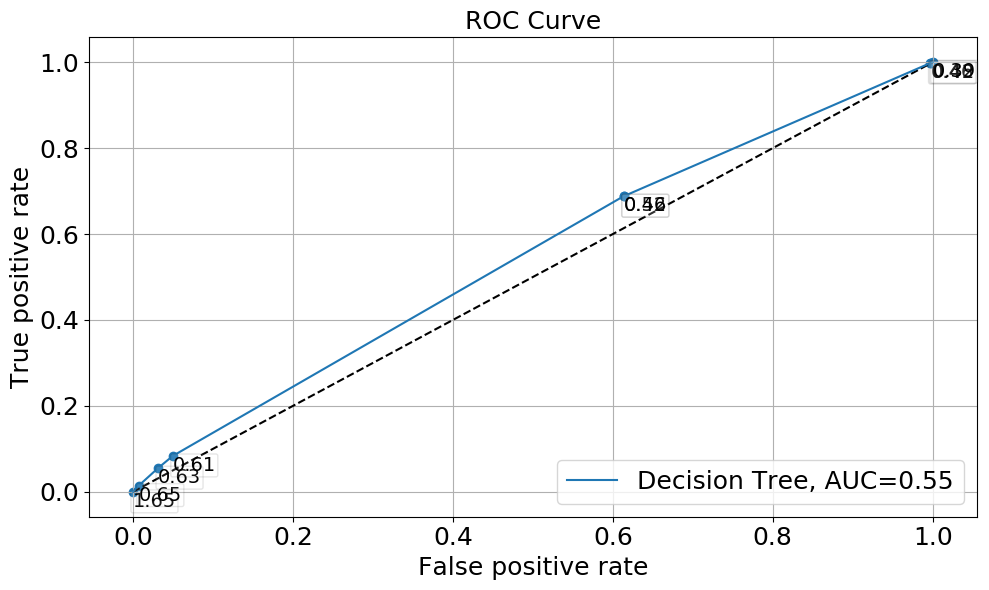

In [94]:
#ROC Curve
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(clf, X_test, y_test, "Decision Tree", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();

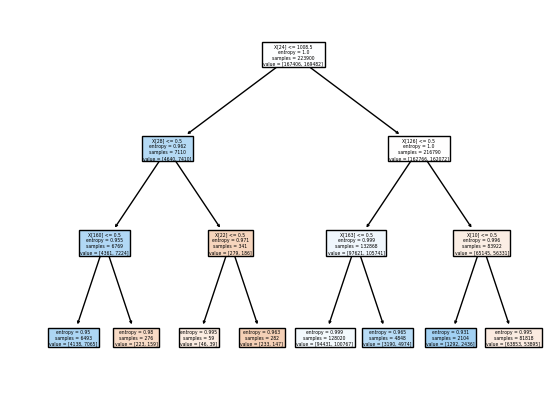

In [95]:
#plot decision tree
from sklearn.tree import plot_tree
plt.figure();
plot_tree(clf, filled=True);
plt.show();

In [96]:
values = sorted(zip(feature_names, clf.feature_importances_), key=lambda x: x[1] * -1)
values

[('all_surveys.RegionID_Central', 0.37170552995798894),
 ('service.max_Year', 0.24364814477180383),
 ('service.ODOMTR_RDNG_surrogate', 0.21611847844977844),
 ('City_QUEBEC              ', 0.10592251599422771),
 ('all_surveys.dealer_no_x_10102B', 0.035188942145104894),
 ('City_NORTH YORK          ', 0.0268435683274837),
 ('all_surveys.InvitationWeekday', 0.0005728203536124288),
 ('service.ODOMTR_RDNG', 0.0),
 ('service.Campaign', 0.0),
 ('service.Customer Pay', 0.0),
 ('service.Customer Pay Only', 0.0),
 ('service.Internal', 0.0),
 ('service.Warranty', 0.0),
 ('vehicle.current_term', 0.0),
 ('vehicle.MSRP_new', 0.0),
 ('service.ServiceTime', 0.0),
 ('all_surveys.number_repairs', 0.0),
 ('service.Campaign_surrogate', 0.0),
 ('service.Customer Pay_surrogate', 0.0),
 ('service.Customer Pay Only_surrogate', 0.0),
 ('service.Warranty_surrogate', 0.0),
 ('service.Internal_surrogate', 0.0),
 ('vehicle.current_term_surrogate', 0.0),
 ('vehicle.MSRP_new_surrogate', 0.0),
 ('all_surveys.Invitatio

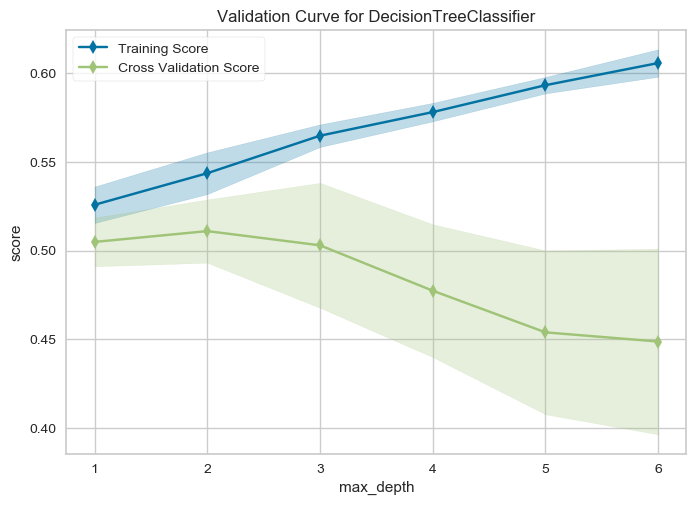

In [94]:
from yellowbrick.model_selection import ValidationCurve
viz = ValidationCurve(DecisionTreeClassifier(), param_name="max_depth", param_range=np.arange(1, 7), cv=5, scoring="roc_auc")
viz.fit(X, y)
viz.poof(outpath='C:/Users/Durugshan/Downloads/default-dt_validation_curve-bias.png')
viz.poof()

# Naive Bayes

In [97]:
#remake dataset
y = all_data_for_model['all_surveys.completedSurvey']
X = all_data_for_model.drop(columns=['all_surveys.completedSurvey'])

#scale numeric variables
from sklearn import preprocessing

for i in ['service.ODOMTR_RDNG', 'service.Campaign', 'service.Customer Pay',
          'service.Customer Pay Only', 'service.Warranty', 'service.Internal', 'vehicle.current_term',
          'vehicle.MSRP_new', 'service.ServiceTime', 'all_surveys.number_repairs']:
    scaler = preprocessing.StandardScaler().fit(X[[i]])
    X[i] = scaler.transform(X[[i]])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
#run NB
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
gnb

y_pred_gnb = gnb.predict(X_test)

gnb.theta_ # Mean of each feature per class
gnb.sigma_ # Variance of each feature per class

array([[1.00104476e+00, 1.02146079e+00, 1.02797964e+00, 1.02447775e+00,
        8.47708323e-01, 1.05404339e+00, 8.60557079e-01, 1.11608329e+00,
        1.03494193e+00, 9.76331725e-01, 4.63906417e-02, 7.77291260e-02,
        1.48225170e-01, 2.15605926e-01, 2.34423640e-01, 1.79027952e-04,
        1.31466140e-02, 3.74619630e-02, 1.41469489e-01, 1.19377088e+01,
        7.06473946e+01, 1.25269329e-04, 2.60943705e+00, 7.12909508e-02,
        1.09795023e+05, 1.42023651e+01, 7.97107133e+01, 1.25269329e-04,
        3.73352276e-02, 6.62595438e-04, 1.75806221e-02, 1.90973528e-04,
        2.12645985e-02, 3.16384839e-04, 3.31651719e-02, 5.13396170e-04,
        5.43462705e-02, 8.47540585e-04, 4.18260049e-03, 1.13928086e-02,
        1.05339491e-02, 1.76497512e-02, 1.55135944e-04, 1.48128253e-02,
        9.10495492e-03, 5.87418326e-03, 3.11851740e-02, 1.90973528e-04,
        4.03938139e-02, 6.56628324e-04, 1.57796575e-02, 2.26808543e-04,
        1.35012483e-02, 1.85000776e-04, 6.14571107e-03, 1.850007

### Performance

In [99]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss

print(confusion_matrix(y_test, y_pred_gnb))
print(classification_report(y_test, y_pred_gnb, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_gnb)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_gnb)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_gnb)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_gnb)))

[[29264 12497]
 [ 8456  5758]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74     41761
           1       0.32      0.41      0.35     14214

    accuracy                           0.63     55975
   macro avg       0.55      0.55      0.55     55975
weighted avg       0.66      0.63      0.64     55975

Accuracy = 0.63
Kappa = 0.10
F1 Score = 0.35
Log Loss = 12.93


# Ensemble

## Voting Classifier

In [100]:
#remake dataset
y = all_data_for_model['all_surveys.completedSurvey']
X = all_data_for_model.drop(columns=['all_surveys.completedSurvey'])

#scale numeric variables
from sklearn import preprocessing

for i in ['service.ODOMTR_RDNG', 'service.Campaign', 'service.Customer Pay',
          'service.Customer Pay Only', 'service.Warranty', 'service.Internal', 'vehicle.current_term',
          'vehicle.MSRP_new', 'service.ServiceTime', 'all_surveys.number_repairs']:
    scaler = preprocessing.MinMaxScaler().fit(X[[i]])
    X[i] = scaler.transform(X[[i]])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
from sklearn.ensemble import VotingClassifier

classifiers = [('DecisionTree', clf), ('NaiveBayes', gnb)]

vcclf =VotingClassifier(estimators = classifiers, voting = 'soft', weights=[2,1])

vcclf = vcclf.fit(X_train, y_train)

In [102]:
y_pred_vcclf = vcclf.predict(X_test)

### Performance

In [103]:
#confusion matrix
confusion_matrix(y_test, y_pred_vcclf)
print(classification_report(y_test, y_pred_vcclf, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_vcclf)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_vcclf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_vcclf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_vcclf)))

              precision    recall  f1-score   support

           0       0.78      0.70      0.73     41761
           1       0.32      0.41      0.36     14214

    accuracy                           0.62     55975
   macro avg       0.55      0.55      0.55     55975
weighted avg       0.66      0.62      0.64     55975

Accuracy = 0.62
Kappa = 0.10
F1 Score = 0.36
Log Loss = 13.00


## Bagging

In [104]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=None, min_samples_split=5), n_estimators=100, max_samples=.10, max_features=0.5, random_state=0)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=5,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [105]:
y_pred_bag_clf = bag_clf.predict(X_test)

### Performance

In [106]:
#confusion matrix
confusion_matrix(y_test, y_pred_bag_clf)
print(classification_report(y_test, y_pred_bag_clf, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_bag_clf)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_bag_clf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_bag_clf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_bag_clf)))

              precision    recall  f1-score   support

           0       0.75      1.00      0.85     41761
           1       0.60      0.01      0.03     14214

    accuracy                           0.75     55975
   macro avg       0.67      0.51      0.44     55975
weighted avg       0.71      0.75      0.64     55975

Accuracy = 0.75
Kappa = 0.02
F1 Score = 0.03
Log Loss = 8.73


## Random Forest Classifier

In [107]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=150, max_depth=None, min_samples_split=5, random_state=0, class_weight={0: 1, 1: 3})

rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [108]:
y_pred_rf_clf = rf_clf.predict(X_test)

### Performance

In [109]:
#confusion matrix
print(confusion_matrix(y_test, y_pred_rf_clf))
print(classification_report(y_test, y_pred_rf_clf, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_rf_clf)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_rf_clf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_rf_clf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_rf_clf)))

[[39587  2174]
 [ 8904  5310]]
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     41761
           1       0.71      0.37      0.49     14214

    accuracy                           0.80     55975
   macro avg       0.76      0.66      0.68     55975
weighted avg       0.79      0.80      0.78     55975

Accuracy = 0.80
Kappa = 0.38
F1 Score = 0.49
Log Loss = 6.84


In [110]:
values = sorted(zip(feature_names, rf_clf.feature_importances_), key=lambda x: x[1] * -1)
values

[('service.ODOMTR_RDNG', 0.11805624418953525),
 ('service.max_Day', 0.10239785735828619),
 ('service.Warranty', 0.0744072223147587),
 ('all_surveys.InvitationDay', 0.07001503173257795),
 ('service.max_Month', 0.06501857049399118),
 ('all_surveys.number_repairs', 0.05961588015451803),
 ('all_surveys.InvitationWeekday', 0.05089641780777931),
 ('service.ServiceTime', 0.045320927055759706),
 ('service.Customer Pay Only', 0.04365049215944375),
 ('all_surveys.InvitationMonth', 0.043311210015808975),
 ('service.Customer Pay', 0.02802106808706841),
 ('service.max_Year', 0.015447446709087542),
 ('service.Campaign', 0.013897722368916341),
 ('service.Customer Pay_surrogate', 0.010355717104259577),
 ('all_surveys.InvitationMonthPeriod_Month Middle', 0.01035295608322103),
 ('all_surveys.InvitationMonthPeriod_Month Beginning', 0.008461528243880715),
 ('all_surveys.InvitationMonthPeriod_Month End', 0.008428300234352072),
 ('vehicle.MSRP_new', 0.007691655541820313),
 ('all_surveys.InvitationYear', 0.0

In [113]:
from sklearn.model_selection import GridSearchCV

hyperparams = {'criterion':('gini', 'entropy'), 
               'n_estimators':[50, 100, 150],
               'max_leaf_nodes': [5, 20],
               'min_samples_split':[5, 10],
               'max_features':[None, 'auto']}
rfgdclf = RandomForestClassifier(random_state=0, max_depth = None, class_weight={0: 1, 1: 3})
gridsearch = GridSearchCV(rfgdclf, hyperparams, cv=5, return_train_score=True)
%time gridsearch.fit(X_train, y_train)

KeyboardInterrupt: 

In [114]:
results = cv_results_to_df(gridsearch.cv_results_)
results

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

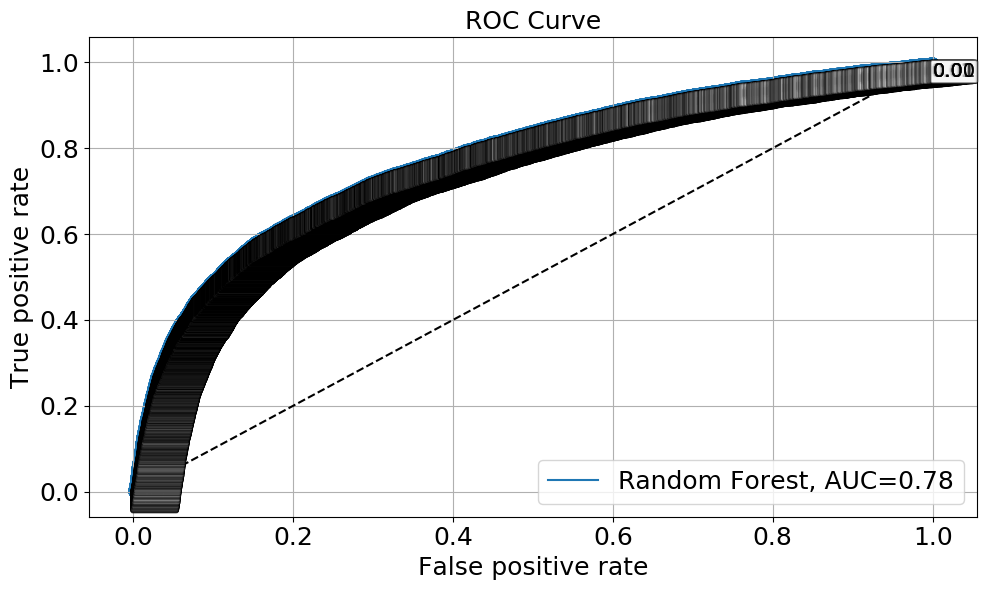

In [115]:
#ROC Curve
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(rf_clf, X_test, y_test, "Random Forest", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();

### Visualization

In [ ]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(RandomForestClassifier(max_depth=None, min_samples_split=10, random_state=0), param_name="n_estimators", param_range=np.arange(100,200,20), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='C:/Users/Durugshan/Downloads/default-rf-n_estimators.png')
viz.poof()

## Boosting

In [246]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=0)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [247]:
y_pred_ada_clf = ada_clf.predict(X_test)

### Performance

In [248]:
#confusion matrix
print(confusion_matrix(y_test, y_pred_ada_clf))
print(classification_report(y_test, y_pred_ada_clf, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_ada_clf)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_ada_clf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_ada_clf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_ada_clf)))

[[41664    97]
 [14110   104]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.85     41761
           1       0.52      0.01      0.01     14214

    accuracy                           0.75     55975
   macro avg       0.63      0.50      0.43     55975
weighted avg       0.69      0.75      0.64     55975

Accuracy = 0.75
Kappa = 0.01
F1 Score = 0.01
Log Loss = 8.77


### Visualization

Wall time: 1min 37s


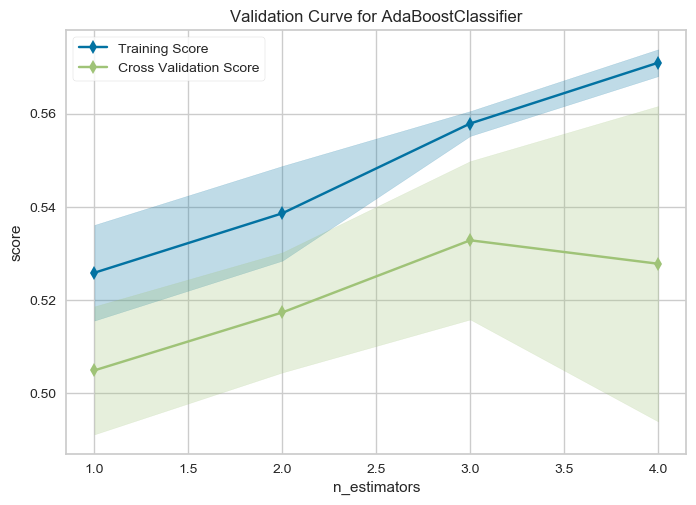

In [113]:
viz = ValidationCurve( AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), random_state=0), param_name="n_estimators", param_range=np.arange(1, 5), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='C:/Users/Durugshan/Downloads/default-ada-n_estimators.png')
viz.poof()

## Gradient Boosting Classifier

In [249]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=1, max_features=1, 
    random_state=0)
gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=1, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [250]:
y_pred_gbt_clf = gbt_clf.predict(X_test)

### Performance

In [251]:
#confusion matrix
print(confusion_matrix(y_test, y_pred_gbt_clf))
print(classification_report(y_test, y_pred_gbt_clf, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_gbt_clf)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_gbt_clf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_gbt_clf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_gbt_clf)))

[[41761     0]
 [14214     0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.85     41761
           1       0.00      0.00      0.00     14214

    accuracy                           0.75     55975
   macro avg       0.37      0.50      0.43     55975
weighted avg       0.56      0.75      0.64     55975

Accuracy = 0.75
Kappa = 0.00
F1 Score = 0.00
Log Loss = 8.77


C:\Users\s5662866\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\s5662866\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [252]:
values = sorted(zip(feature_names, gbt_clf.feature_importances_ ), key=lambda x: x[1] * -1)
values

[('all_surveys.Channel_Sales', 0.18132538557677438),
 ('all_surveys.RegionID_Eastern', 0.10964193819281329),
 ('service.ODOMTR_RDNG_surrogate', 0.0811859672383438),
 ('City_RICHMOND            ', 0.067131563103998),
 ('vehicle.MSRP_new_surrogate', 0.05281455046359662),
 ('all_surveys.InvitationQuarter_Q4', 0.052347109996455844),
 ('all_surveys.dealer_no_x_5105B', 0.03436332246558664),
 ('City_SHERBROOKE          ', 0.030615649473498947),
 ('vehicle.current_term_surrogate', 0.028825554236800856),
 ('City_CALGARY             ', 0.02783883488963185),
 ('City_TORONTO             ', 0.026169982413025646),
 ('all_surveys.dealer_no_x_5150B', 0.025221729223032667),
 ('Province_AB        ', 0.02520342849199599),
 ('service.max_Year', 0.020208791765244708),
 ('all_surveys.dealer_no_x_9140B', 0.019846131961261802),
 ('all_surveys.OptOutStatus_Opted Out of all BMW or MCX Surveys',
  0.017577500405310878),
 ('all_surveys.dealer_no_x_6103B', 0.017067213361053064),
 ('all_surveys.InvitationQuarter_Q2

### Visualization

Wall time: 8min 20s


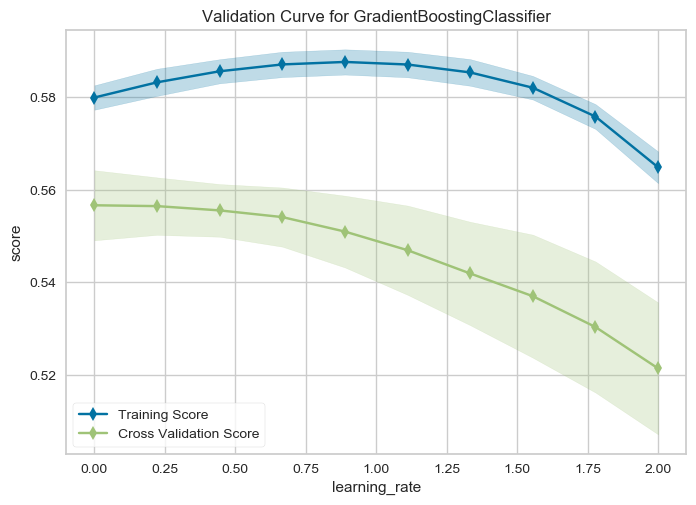

In [118]:
viz = ValidationCurve(GradientBoostingClassifier(n_estimators=100, max_depth=1, max_features=1, random_state=0), param_name="learning_rate", param_range=np.linspace(0.001,2,10), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='C:/Users/Durugshan/Downloads/default-gbm-learning_rate.png')
viz.poof()

Wall time: 1min 24s


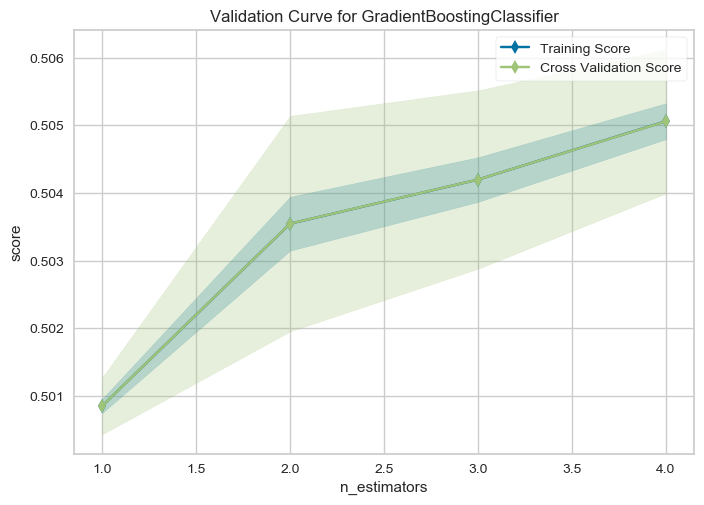

In [119]:
viz = ValidationCurve(GradientBoostingClassifier(learning_rate=1.0, max_depth=1, max_features=1, random_state=0), param_name="n_estimators", param_range=np.arange(1, 5), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='C:/Users/Durugshan/Downloads/default-gbm-n_estimators.png')
viz.poof()

## XG Boost

In [253]:
import xgboost
from xgboost import XGBClassifier

xg_clf = XGBClassifier(n_estimators=100, max_depth=3)

xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [254]:
y_pred_xg_clf = xg_clf.predict(X_test)

### Performance

In [255]:
#confusion matrix
confusion_matrix(y_test, y_pred_xg_clf)
print(classification_report(y_test, y_pred_xg_clf, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_xg_clf)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_xg_clf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_xg_clf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_xg_clf)))

              precision    recall  f1-score   support

           0       0.75      1.00      0.85     41761
           1       0.57      0.00      0.00     14214

    accuracy                           0.75     55975
   macro avg       0.66      0.50      0.43     55975
weighted avg       0.70      0.75      0.64     55975

Accuracy = 0.75
Kappa = 0.00
F1 Score = 0.00
Log Loss = 8.77


In [256]:
values = sorted(zip(feature_names, xg_clf.feature_importances_), key=lambda x: x[1] * -1)
values

[('all_surveys.RegionID_Central', 0.1187766),
 ('all_surveys.Channel_Sales', 0.081236735),
 ('Province_ON        ', 0.04818856),
 ('all_surveys.RegionID_Eastern', 0.04389607),
 ('all_surveys.dealer_no_x_10123B', 0.043800674),
 ('Province_QC        ', 0.035125263),
 ('City_CALGARY             ', 0.030762605),
 ('service.ODOMTR_RDNG', 0.026740866),
 ('all_surveys.InvitationMonth', 0.026081076),
 ('all_surveys.dealer_no_x_6185B', 0.024810692),
 ('all_surveys.dealer_no_x_6120B', 0.022041596),
 ('all_surveys.OptOutStatus_Not Opted Out', 0.021497462),
 ('all_surveys.dealer_no_x_5150B', 0.020479146),
 ('all_surveys.InvitationYear', 0.020205064),
 ('all_surveys.dealer_no_x_6117B', 0.019217258),
 ('all_surveys.dealer_no_x_5155B', 0.018819401),
 ('all_surveys.dealer_no_x_5101B', 0.017386664),
 ('all_surveys.InvitationDay', 0.016064905),
 ('vehicle.new_cde_N', 0.014464693),
 ('all_surveys.InvitationMonthPeriod_Month Middle', 0.01429321),
 ('all_surveys.dealer_no_x_10102B', 0.013533454),
 ('all_su

### Visualization

KeyboardInterrupt: 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
C:\Users\Durugshan\Anaconda3\lib\site-packages\matplotlib\axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


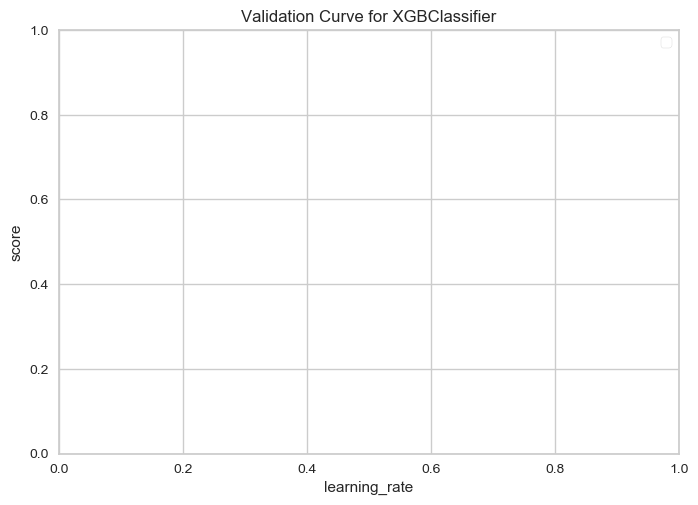

In [124]:
viz = ValidationCurve(XGBClassifier(n_estimators=100, max_depth=3, random_state=0), param_name="learning_rate", param_range=np.linspace(0.001,2,30), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='C:/Users/Durugshan/Downloads/default-xgboost-learning_rate.png')
viz.poof()

KeyboardInterrupt: 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


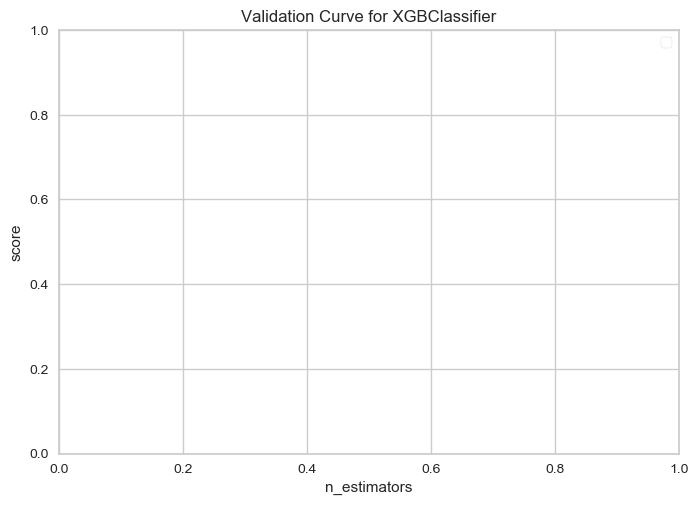

In [125]:
viz = ValidationCurve(XGBClassifier(learning_rate=1.0, max_depth=3, random_state=0), param_name="n_estimators", param_range=np.arange(1, 10), cv=5, scoring="roc_auc")
%time viz.fit(X, y)
viz.poof(outpath='C:/Users/Durugshan/Downloads/default-xgboost-n_estimators.png')
viz.poof()

## Stacking

In [257]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

scclf = StackingClassifier(
    classifiers=classifiers, meta_classifier=LogisticRegression(), 
    use_probas=True, average_probas=False)

scclf = vcclf.fit(X_train, y_train)

In [258]:
y_pred_scclf = scclf.predict(X_test)

### Performance

In [259]:
#confusion matrix
confusion_matrix(y_test, y_pred_scclf)
print(classification_report(y_test, y_pred_scclf, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_scclf)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_scclf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_scclf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_scclf)))

              precision    recall  f1-score   support

           0       0.78      0.70      0.73     41761
           1       0.32      0.41      0.36     14214

    accuracy                           0.62     55975
   macro avg       0.55      0.55      0.55     55975
weighted avg       0.66      0.62      0.64     55975

Accuracy = 0.62
Kappa = 0.10
F1 Score = 0.36
Log Loss = 12.99


# Questions

### Are there common patterns between customer engagement (completed or abandoned)? 

In [124]:
all_data_final_questions_2['all_surveys.ResponseStatus'].unique()

array(['Completed', 'No Response', 'In Progress', 'Abandoned', 'UNKNOWN',
       'Rejected'], dtype=object)

In [125]:
q4_filtered = all_data_final_questions_2[(all_data_final_questions_2['all_surveys.ResponseStatus'] == 'Completed') | (all_data_final_questions_2['all_surveys.ResponseStatus'] == 'Abandoned')]

### On average how much time do customers take before filling out surveys?

In [126]:
all_data_final_questions_2['all_surveys.completedSurvey'].unique()

array([1, 0], dtype=int64)

In [127]:
q5_filtered = all_data_final_questions_2[all_data_final['all_surveys.completedSurvey']== 1]

C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [128]:
q5_filtered['all_surveys.Time_to_Complete'] = q5_filtered['all_surveys.Time_to_Complete'].astype(int)

C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [129]:
q5_filtered.groupby('Name')['all_surveys.Time_to_Complete'].mean().sort_values(ascending=False)

Name
Georgian BMW                  33.190541
Park Avenue BMW               30.179530
BMW St.John's                 29.903114
Pfaff BMW                     28.126643
Edmonton BMW                  27.470032
Birchwood BMW                 27.333069
BMW Toronto                   26.953016
Auto West BMW                 26.811511
Canbec BMW                    26.726660
BMW Levis                     26.693333
BMW Sainte Julie              26.388205
Budds' BMW Hamilton           26.330317
Brian Jessel BMW              26.144798
Trois Rivieres BMW            26.084362
Budds' BMW                    25.828084
BMW Autohaus                  25.722556
Policaro BMW                  25.703952
BMW Ville De Québec           25.686075
BMW Sherbrooke                25.582798
BMW Newmarket                 25.332494
BMW Grand River               25.042023
BMW West Island               24.892074
Park Shore BMW                24.836966
Hamel BMW                     24.795422
Grenier BMW                   24.71

In [130]:
q5_filtered.groupby('all_surveys.RegionID')['all_surveys.Time_to_Complete'].mean().sort_values(ascending=False)

all_surveys.RegionID
Central    25.088600
Western    24.296341
Eastern    24.032503
Name: all_surveys.Time_to_Complete, dtype: float64

In [131]:
q5_filtered.groupby('all_surveys.Brand')['all_surveys.Time_to_Complete'].mean().sort_values(ascending=False)

all_surveys.Brand
BMW      24.508936
BMW i    21.019027
Name: all_surveys.Time_to_Complete, dtype: float64

In [132]:
q5_filtered.groupby('Province')['all_surveys.Time_to_Complete'].mean().sort_values(ascending=False)

Province
NS            29.903114
NL            29.903114
MB            27.333069
QC            25.115553
AB            24.849547
ON            24.256355
BC            23.767065
SK            22.825617
UNKNOWN       22.547101
NB            21.427807
Name: all_surveys.Time_to_Complete, dtype: float64

### Which geographic regions or retailers have higher/lower survey completion rates?  

### Are there any particular retailers or service advisors with higher completion rates? 

In [133]:
q6_filtered = all_data_final_questions_2
q6_filtered.groupby(['Province','all_surveys.RegionID', 'Name'])['all_surveys.completedSurvey'].mean().sort_values(ascending=False)

Province    all_surveys.RegionID  Name                      
ON          Eastern               Palladino BMW                 0.466667
                                  BMW Kingston                  0.466019
QC          Central               BMW Levis                     0.436364
                                  Hamel BMW                     0.415730
NB          Central               BMW Moncton                   0.412698
QC          Central               BMW Sherbrooke                0.407407
                                  Trois Rivieres BMW            0.382353
            Eastern               BMW Sherbrooke                0.380402
ON          Eastern               Georgian BMW                  0.366667
QC          Eastern               BMW Levis                     0.355623
NS          Central               BMW St.John's                 0.353535
NL          Central               BMW St.John's                 0.353535
QC          Eastern               BMW Ville De Québec          

In [134]:
q6_filtered.groupby('all_surveys.RegionID')['all_surveys.completedSurvey'].mean().sort_values(ascending=False)

all_surveys.RegionID
Eastern    0.285848
Western    0.246781
Central    0.223150
Name: all_surveys.completedSurvey, dtype: float64

In [135]:
q6_filtered.groupby('Province')['all_surveys.completedSurvey'].mean().sort_values(ascending=False)

Province
NB            0.319476
AB            0.292826
QC            0.291818
UNKNOWN       0.279595
NS            0.270980
NL            0.270980
MB            0.260107
SK            0.244252
ON            0.227556
BC            0.226999
Name: all_surveys.completedSurvey, dtype: float64

### Are there any particular retailers or service advisors with higher invalid email addresses? 

In [139]:
q1_filtered = all_data_final_questions_1
q1_filtered['all_surveys.DispositionDetail'].unique()

array(['Accepted', 'Customer opted out of satisfaction survey (BMW)',
       'Company', 'Invalid email: matches retailer domain',
       'Invited within 90 days to service survey',
       'Invalid email: no email email indicated',
       'Customer sent BMW survey in last 90 days',
       'Blank/NULL Email Address', 'Driver record too old',
       'BMW Retailer/Group Associate', 'Do not send flag',
       'Invalid email: formatting errors', 'Platform Data Rejection',
       'Incorrect country', 'Completed', 'Invited', 'U.S. Transfer',
       'Removed', 'Duplicate record in same file', 'UNKNOWN',
       'Model description is blank/null',
       "Customer's gender is blank/NULL", 'Other',
       'Invalid or blank/null retailer code', 'Invalid model',
       'Invalid or blank/null retailer name',
       'Invalid or missing sale type'], dtype=object)

In [140]:
q1_filtered = q1_filtered[(q1_filtered['all_surveys.DispositionDetail'] == 'Invalid email: matches retailer domain') | (q1_filtered['all_surveys.DispositionDetail'] == 'Invalid email: no email email indicated') | (q1_filtered['all_surveys.DispositionDetail'] == 'Invalid email: formatting errors')]

In [141]:
q1_filtered.groupby('Name')['all_surveys.RespondentId'].count().sort_values(ascending=False)

Name
Budds' BMW                    268
BMW Langley                   249
BMW Laval                     237
Maranello BMW                 213
Brian Jessel BMW              200
Auto West BMW                 185
Pfaff BMW                     171
BMW Autohaus                  155
Parkview BMW                  151
BMW Grand River               148
Overseas Motors               142
BMW London                    115
Endras BMW                    114
BMW Ville De Québec           112
BMW Toronto                   110
Canbec BMW                    109
Brian Jessel BMW Pre-Owned    101
Georgian BMW                   99
Park Shore BMW                 98
UNKNOWN                        94
Park Avenue BMW                90
BMW Markham                    85
The BMW Store                  81
BMW West Island                77
Elite BMW                      76
Birchwood BMW                  71
Calgary BMW                    67
Hamel BMW                      66
Policaro BMW                   61
BMW Sarni

### Does the customer pay amount, warranty amount or the MSRP on the vehicle affect survey completion? If so, what are some suggestions to change this? 

In [182]:
q7_filtered = all_data_final_questions_2
q7_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278576 entries, 8099 to 589434
Data columns (total 74 columns):
all_surveys.RespondentId               278576 non-null int64
all_surveys.SampleReceivedDate         278576 non-null datetime64[ns]
all_surveys.dealer_nme                 278576 non-null object
all_surveys.dealer_no_x                278576 non-null object
all_surveys.InvitationStatus           278576 non-null object
all_surveys.DispositionDetail          278576 non-null object
all_surveys.ResponseStatus             278576 non-null object
all_surveys.Associatenumber            278576 non-null object
all_surveys.vin                        278576 non-null object
all_surveys.UniqueID                   278576 non-null object
all_surveys.Brand                      278576 non-null object
all_surveys.Channel                    278576 non-null object
all_surveys.SurveyType                 278576 non-null object
all_surveys.Metro                      278576 non-null object
all_surveys

In [183]:
q7_filtered = q7_filtered[['service.Customer Pay', 'service.Customer Pay Only', 'service.Warranty', 'vehicle.MSRP_new', 'all_surveys.completedSurvey', 'all_surveys.Time_to_Complete']]

In [200]:
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000]
q7_filtered.groupby([pd.cut(q7_filtered['service.Customer Pay'], bins)])['all_surveys.completedSurvey'].agg(['mean', 'count'])

,mean,count
service.Customer Pay,,
"(0, 10000]",0.238331,49469
"(10000, 20000]",0.209302,43
"(20000, 30000]",0.600000,5
"(30000, 40000]",0.000000,1
"(40000, 50000]",NaN,0
"(50000, 60000]",NaN,0
"(60000, 70000]",NaN,0
"(70000, 80000]",NaN,0
"(80000, 90000]",NaN,0


In [201]:
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000]
q7_filtered.groupby([pd.cut(q7_filtered['service.Customer Pay Only'], bins)])['all_surveys.completedSurvey'].agg(['mean', 'count'])

,mean,count
service.Customer Pay Only,,
"(0, 10000]",0.242867,86566
"(10000, 20000]",0.214286,168
"(20000, 30000]",0.307692,26
"(30000, 40000]",0.000000,6
"(40000, 50000]",0.200000,5
"(50000, 60000]",1.000000,1
"(60000, 70000]",0.000000,1
"(70000, 80000]",NaN,0
"(80000, 90000]",NaN,0


In [202]:
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000]
q7_filtered.groupby([pd.cut(q7_filtered['service.Warranty'], bins)])['all_surveys.completedSurvey'].agg(['mean', 'count'])

,mean,count
service.Warranty,,
"(0, 10000]",0.242172,172039
"(10000, 20000]",0.264851,404
"(20000, 30000]",0.201613,124
"(30000, 40000]",0.279570,93
"(40000, 50000]",0.166667,24
"(50000, 60000]",0.166667,12
"(60000, 70000]",0.125000,8
"(70000, 80000]",0.300000,10
"(80000, 90000]",0.333333,3


In [191]:
q7_filtered['Total_Repair'] = q7_filtered['service.Warranty'] + q7_filtered['service.Customer Pay'] + q7_filtered['service.Customer Pay Only']

C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [203]:
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000]
q7_filtered.groupby([pd.cut(q7_filtered['Total_Repair'], bins)])['all_surveys.completedSurvey'].agg(['mean', 'count'])

,mean,count
Total_Repair,,
"(0, 10000]",0.242433,258925
"(10000, 20000]",0.248466,652
"(20000, 30000]",0.232558,172
"(30000, 40000]",0.268519,108
"(40000, 50000]",0.171429,35
"(50000, 60000]",0.153846,13
"(60000, 70000]",0.200000,10
"(70000, 80000]",0.300000,10
"(80000, 90000]",0.333333,3


### Does the time that the vehicle stays in service (difference between service in/out dates) affect survey completion? 

In [143]:
q8_filtered = all_data_final_questions_2

In [204]:
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400]
q8_filtered.groupby([pd.cut(q8_filtered['service.ServiceTime'], bins)])['all_surveys.completedSurvey'].agg(['mean', 'count'])

,mean,count
service.ServiceTime,,
"(0, 25]",0.242689,259385
"(25, 50]",0.238077,2663
"(50, 75]",0.263374,486
"(75, 100]",0.147541,183
"(100, 125]",0.144737,76
"(125, 150]",0.250000,36
"(150, 175]",0.000000,19
"(175, 200]",0.181818,11
"(200, 225]",0.666667,3


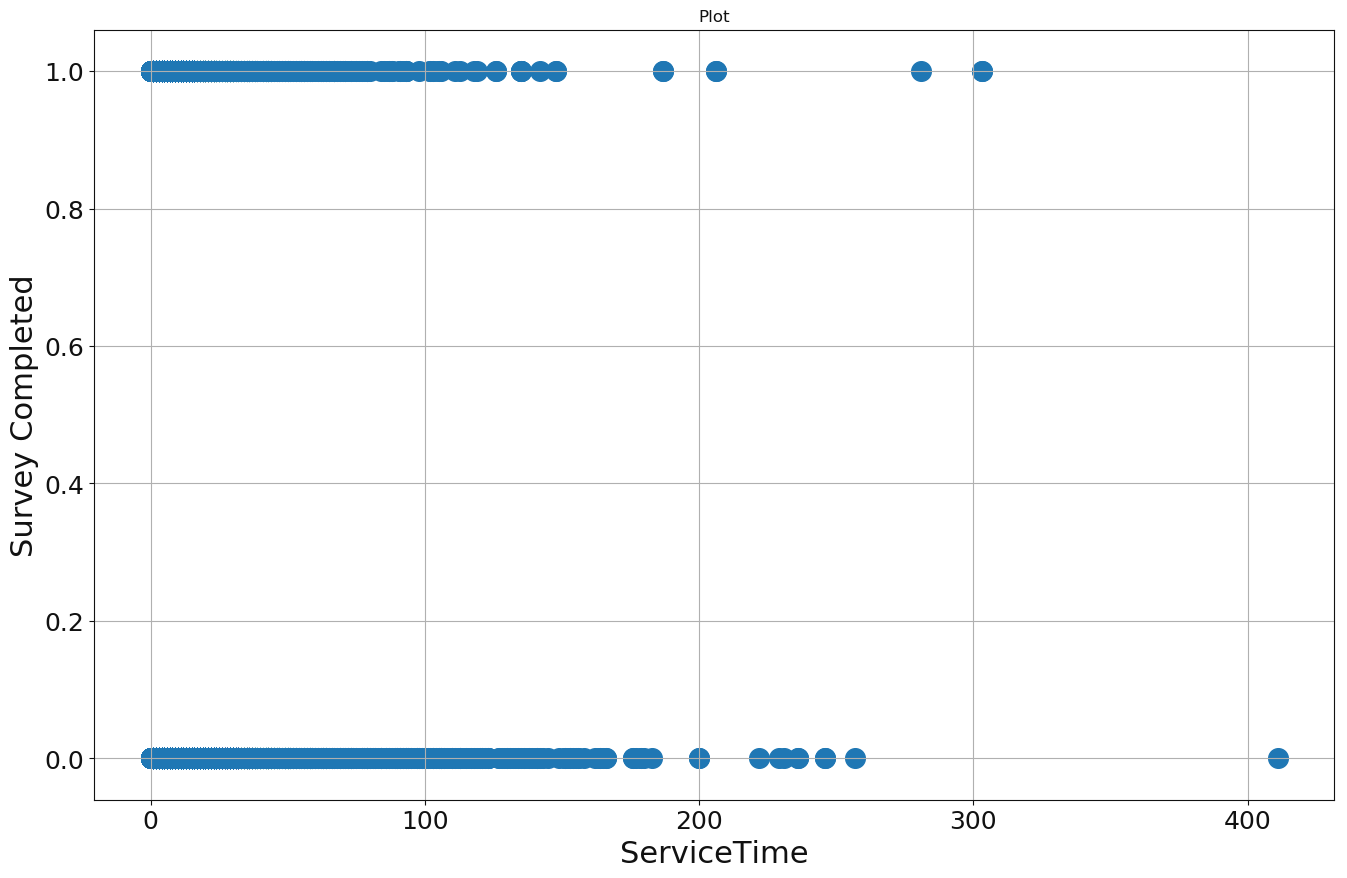

In [145]:
# Plot the points
plt.style.use('default');
plt.figure(figsize=(16, 10));
plt.grid(True);

plt.scatter(q8_filtered['service.ServiceTime'], q8_filtered['all_surveys.completedSurvey'], s=200);
plt.title("Plot");
plt.xlabel('ServiceTime', fontsize=22);
plt.ylabel('Survey Completed', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

### Do new vehicle owners engage differently with surveys compared to pre-owned purchasers?  

In [161]:
all_data_final_questions_1['vehicle.new_cde'].unique() 

array(['U', 'N', 'NO_INFO'], dtype=object)

In [163]:
q2_filtered = all_data_final_questions_1[(all_data_final_questions_1['vehicle.new_cde'] == 'N') | (all_data_final_questions_1['vehicle.new_cde'] == 'U')]

In [164]:
q2_filtered['all_surveys.Time_to_Complete'] = q2_filtered['all_surveys.Time_to_Complete'].astype(int)
q2_filtered.groupby('vehicle.new_cde')['all_surveys.Time_to_Complete'].mean().sort_values(ascending=False)

C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


vehicle.new_cde
N    5.838267
U    4.995062
Name: all_surveys.Time_to_Complete, dtype: float64

In [205]:
q2_filtered.groupby(['Province','all_surveys.RegionID', 'vehicle.new_cde'])['all_surveys.completedSurvey'].mean().sort_values(ascending=False)

SyntaxError: invalid syntax (<ipython-input-205-e20bee8fc9d1>, line 1)

### Once a customer opts out from surveys BMW is unable to send any survey invitations. Therefore it’s also very important that we understand opt-out behaviour. Please identify patterns behind opt-out behaviour, including recommendations.

In [166]:
q3_filtered = all_data_final_questions_2

In [167]:
q3_filtered['all_surveys.OptOutStatus'].unique()

array(['Not Opted Out', 'Opted Out of all BMW or MCX Surveys'],
      dtype=object)

In [168]:
q3_filtered['NotOptedOut'] = np.where(q3_filtered['all_surveys.OptOutStatus'] == 'Not Opted Out', 1, 0)

C:\Users\Durugshan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [169]:
#drop unneeded columns
q3_filtered = q3_filtered.drop(columns=['all_surveys.RespondentId', 'all_surveys.SampleReceivedDate', 'all_surveys.SampleReceivedYear',
                                        'all_surveys.SampleReceivedMonth', 'all_surveys.SampleReceivedDay', 'all_surveys.SampleReceivedHour',
                                        'all_surveys.OptOutStatus','all_surveys.InvitationYear', 'all_surveys.InvitationMonth','all_surveys.InvitationDay', 'all_surveys.InvitationHour',
                                        'all_surveys.dealer_nme', 'all_surveys.InvitationStatus', 'all_surveys.DispositionDetail', 'all_surveys.ResponseStatus',
                                        'all_surveys.Associatenumber', 'all_surveys.vin', 'all_surveys.UniqueID',
                                        'all_surveys.RO_NUM','all_surveys.InvitationDate', 'all_surveys.EventDate',
                                        'all_surveys.CompletedDate', 'service.id', 'service.dealer_name',
                                        'service.ServiceInD', 'service.ServiceOut', 'vehicle.book_dte',
                                        'vehicle.Id', 'vehicle.vin', 'vehicle.book_dte','vehicle.rgn_cde', 
                                        'vehicle.dealer_nme', 'vehicle.dealer_no','vehicle.Date_End', 'service.max_date',
                                         'all_surveys.Time_to_Complete', 'all_surveys.Times_Completed', 'all_surveys.completedSurvey'])

In [170]:
q3_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278576 entries, 8099 to 589434
Data columns (total 37 columns):
all_surveys.dealer_no_x                278576 non-null object
all_surveys.Brand                      278576 non-null object
all_surveys.Channel                    278576 non-null object
all_surveys.SurveyType                 278576 non-null object
all_surveys.Metro                      278576 non-null object
all_surveys.RegionID                   278576 non-null object
service.ODOMTR_RDNG                    278576 non-null float64
service.Campaign                       278576 non-null float64
service.Customer Pay                   278576 non-null float64
service.Customer Pay Only              278576 non-null float64
service.Internal                       278576 non-null float64
service.Warranty                       278576 non-null float64
vehicle.purchase_type                  278576 non-null object
vehicle.current_term                   278576 non-null float64
vehicle.new

In [171]:
q3_filtered = pd.get_dummies(q3_filtered, prefix=['all_surveys.dealer_no_x', 'all_surveys.Brand',
'all_surveys.Channel', 'all_surveys.SurveyType', 'all_surveys.Metro', 
'all_surveys.RegionID', 'vehicle.purchase_type', 'vehicle.new_cde', 'Retailer', 'Brand', 'Region', 'Name', 'City', 'Province'], columns=['all_surveys.dealer_no_x', 'all_surveys.Brand',
'all_surveys.Channel', 'all_surveys.SurveyType', 'all_surveys.Metro',
'all_surveys.RegionID', 'vehicle.purchase_type', 'vehicle.new_cde', 'Retailer', 'Brand', 'Region', 'Name', 'City', 'Province'])

In [172]:
q3_filtered.head()

,service.ODOMTR_RDNG,service.Campaign,service.Customer Pay,service.Customer Pay Only,service.Internal,service.Warranty,vehicle.current_term,vehicle.MSRP_new,service.ServiceTime,all_surveys.number_repairs,...,Province_AB,Province_BC,Province_MB,Province_NB,Province_NL,Province_NS,Province_ON,Province_QC,Province_SK,Province_UNKNOWN
8099,33017.0,0.0,84.50,0.0,0.0,257.11,0.0,0.0,2,1,...,0,0,0,0,0,0,1,0,0,0
8100,57285.0,0.0,239.85,0.0,0.0,320.04,0.0,0.0,1,4,...,0,0,0,0,0,0,0,1,0,0
8101,34821.0,0.0,73.99,0.0,0.0,2565.23,0.0,0.0,3,5,...,0,0,0,0,0,0,0,1,0,0
8102,5418.0,0.0,0.00,0.0,0.0,116.84,0.0,0.0,1,2,...,0,0,0,0,0,0,1,0,0,0
8103,40825.0,0.0,0.00,0.0,0.0,1002.09,0.0,0.0,2,10,...,0,0,1,0,0,0,0,0,0,0


In [173]:
#create x and y of dataset
b = q3_filtered['NotOptedOut']
A = q3_filtered.drop(columns=['NotOptedOut'])

In [174]:
#scale numeric variables
for i in ['service.ODOMTR_RDNG', 'service.Campaign', 'service.Customer Pay',
          'service.Customer Pay Only', 'service.Warranty', 'service.Internal', 'vehicle.current_term',
          'vehicle.MSRP_new', 'service.ServiceTime', 'all_surveys.number_repairs']:
    scaler = preprocessing.StandardScaler().fit(A[[i]])
    A[i] = scaler.transform(A[[i]])

In [175]:
#create train test
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=42)

In [176]:
#create decision tree
q3_clf = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=10, min_samples_leaf=10, max_depth=10, max_leaf_nodes=5)
q3_clf.fit(A_train, b_train)

b_pred_dt = q3_clf.predict(A_test)

feature_names = A.columns
class_names = [str(x) for x in q3_clf.classes_]

In [177]:
#confusion matrix
confusion_matrix(b_test, b_pred_dt)

array([[    0,   130],
       [    0, 55586]], dtype=int64)

In [178]:
#classification report
print(classification_report(b_test, b_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       1.00      1.00      1.00     55586

    accuracy                           1.00     55716
   macro avg       0.50      0.50      0.50     55716
weighted avg       1.00      1.00      1.00     55716



C:\Users\Durugshan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [179]:
#scores
print("Accuracy = {:.2f}".format(accuracy_score(b_test, b_pred_dt)))
print("Kappa = {:.2f}".format(cohen_kappa_score(b_test, b_pred_dt)))
print("F1 Score = {:.2f}".format(f1_score(b_test, b_pred_dt)))
print("Log Loss = {:.2f}".format(log_loss(b_test, b_pred_dt)))

Accuracy = 1.00
Kappa = 0.00
F1 Score = 1.00
Log Loss = 0.08


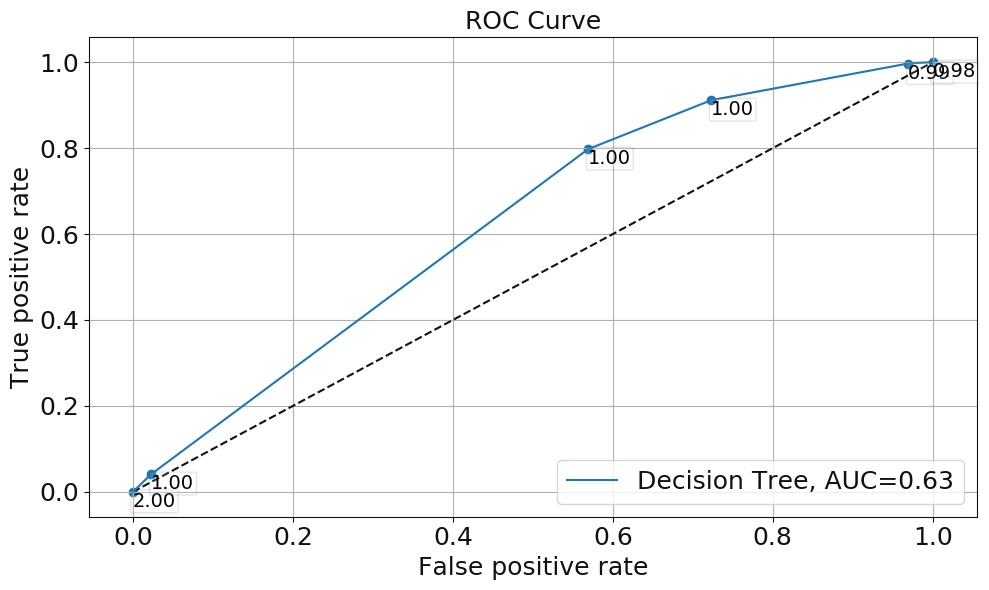

In [180]:
#ROC Curve
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(q3_clf, A_test, b_test, "Decision Tree", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();

In [181]:
values = sorted(zip(feature_names, q3_clf.feature_importances_), key=lambda x: x[1] * -1)
values

[('all_surveys.number_repairs', 0.3808435388152225),
 ('service.ODOMTR_RDNG', 0.2331314993924504),
 ('Province_BC        ', 0.20465027871215213),
 ('City_OAKVILLE            ', 0.181374683080175),
 ('service.Campaign', 0.0),
 ('service.Customer Pay', 0.0),
 ('service.Customer Pay Only', 0.0),
 ('service.Internal', 0.0),
 ('service.Warranty', 0.0),
 ('vehicle.current_term', 0.0),
 ('vehicle.MSRP_new', 0.0),
 ('service.ServiceTime', 0.0),
 ('service.ODOMTR_RDNG_surrogate', 0.0),
 ('service.Campaign_surrogate', 0.0),
 ('service.Customer Pay_surrogate', 0.0),
 ('service.Customer Pay Only_surrogate', 0.0),
 ('service.Warranty_surrogate', 0.0),
 ('service.Internal_surrogate', 0.0),
 ('vehicle.current_term_surrogate', 0.0),
 ('vehicle.MSRP_new_surrogate', 0.0),
 ('service.max_Year', 0.0),
 ('service.max_Month', 0.0),
 ('service.max_Day', 0.0),
 ('service.max_Hour', 0.0),
 ('all_surveys.dealer_no_x_10102B', 0.0),
 ('all_surveys.dealer_no_x_10102I', 0.0),
 ('all_surveys.dealer_no_x_10103B', 0.0

# --------------------------------------------------------------------------------------------
# DID NOT RUN

# KNN

In [ ]:
#remake dataset
all_data_for_model = all_data_final

all_data_for_model = all_data_for_model.drop(columns = ['all_surveys.DispositionDetail', 'all_surveys.ResponseStatus',
                                                        'all_surveys.Associatenumber', 'all_surveys.EventDate', 'service.dealer_nme:',
                                                        'service.dealer_no_y', 'service.service_adv_no', 'service.ServiceInD',
                                                        'service.ServiceOut', 'vehicle.Id', 'vehicle.vin', 'vehicle.rgn_cde'])

In [ ]:
#one hot encoding for Decision Trees
all_data_for_model = pd.get_dummies(all_data_for_model, prefix=['all_surveys.dealer_no_x', 'all_surveys.InvitationStatus', 'all_surveys.Brand',
'all_surveys.Channel', 'all_surveys.SurveyType', 'all_surveys.Metro', 'all_surveys.OptOutStatus',
'all_surveys.RegionID', 'service.city', 'vehicle.purchase_type', 'vehicle.new_cde'], columns=['all_surveys.dealer_no_x', 'all_surveys.InvitationStatus', 'all_surveys.Brand',
'all_surveys.Channel', 'all_surveys.SurveyType', 'all_surveys.Metro', 'all_surveys.OptOutStatus',
'all_surveys.RegionID', 'service.city', 'vehicle.purchase_type', 'vehicle.new_cde'])

In [ ]:
all_data_for_model.info()

In [ ]:
#remake dataset
y = all_data_for_model['all_surveys.completedSurvey']
X = all_data_for_model.drop(columns=['all_surveys.completedSurvey'])

#scale numeric variables
from sklearn import preprocessing

for i in ['service.ODOMTR_RDNG', 'service.Campaign', 'service.Customer Pay',
          'service.Customer Pay Only', 'service.Warranty', 'vehicle.current_term',
          'vehicle.MSRP_new', 'all_surveys.Time_to_Complete', 'service.ServiceTime',
          'all_surveys.number_repairs']:
    scaler = preprocessing.StandardScaler().fit(X[[i]])
    X[i] = scaler.transform(X[[i]])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=850)
knn_clf.fit(X_train, y_train)

In [ ]:
from sklearn.neighbors import KDTree

knn_clf = KDTree(X_train, leaf_size=850) 

In [ ]:
y_pred_knn = knn_clf.predict(X_test)

#model parameters
knn_clf.effective_metric_
knn_clf.effective_metric_params_

Model Performance

In [ ]:
#confusion matrix
print(confusion_matrix(y_test, y_pred_knn))

#classification report
print(classification_report(y_test, y_pred_knn, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_knn)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_knn)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_knn)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_knn)))

#roc curve
#plt.style.use('default');
#figure = plt.figure(figsize=(10, 6));    
#ax = plt.subplot(1, 1, 1);
#plot_roc(knn_clf, X_test, y_test, "GNB", ax)
#plt.legend(loc='lower right', fontsize=18);
#plt.tight_layout();

# Logistic Regression

In [ ]:
#remake dataset
all_data_for_model = all_data_final

all_data_for_model = all_data_for_model.drop(columns = ['all_surveys.DispositionDetail', 'all_surveys.ResponseStatus',
                                                        'all_surveys.Associatenumber', 'all_surveys.EventDate', 'service.dealer_nme:',
                                                        'service.dealer_no_y', 'service.service_adv_no', 'service.ServiceInD',
                                                        'service.ServiceOut', 'vehicle.Id', 'vehicle.vin', 'vehicle.rgn_cde'])

In [ ]:
#remake dataset
y = all_data_for_model['all_surveys.completedSurvey']
X = all_data_for_model.drop(columns=['all_surveys.completedSurvey'])

#scale numeric variables
from sklearn import preprocessing

for i in ['service.ODOMTR_RDNG', 'service.Campaign', 'service.Customer Pay',
          'service.Customer Pay Only', 'service.Warranty', 'vehicle.current_term',
          'vehicle.MSRP_new', 'all_surveys.Time_to_Complete', 'service.ServiceTime',
          'all_surveys.number_repairs']:
    scaler = preprocessing.StandardScaler().fit(X[[i]])
    X[i] = scaler.transform(X[[i]])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=0, max_iter = 100, solver='saga',multi_class='multinomial')
log_clf.fit(X_train, y_train)

In [ ]:
y_pred_log = log_clf.predict(X_test)

Model Performance

In [ ]:
#confusion matrix
print(confusion_matrix(y_test, y_pred_log))

#classification report
print(classification_report(y_test, y_pred_log, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_log)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_log)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_log)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_log)))

# SVM Linear

In [ ]:
svm_clf = SVC(kernel="linear", C=0.025)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

#parameters
svm_clf.n_support_
svm_clf.support_vectors_
svm_clf.dual_coef_
svm_clf.intercept_

Model Performance

In [ ]:
#confusion matrix
print(confusion_matrix(y_test, y_pred_svm))

#classification report
print(classification_report(y_test, y_pred_svm, target_names=class_names))

#scores
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_svm)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_svm)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_svm)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_svm)))